Just having a quick look at the WASP-63 data, looks different

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
from astropy.convolution import convolve, Box1DKernel
from scipy.interpolate import interp1d
from scipy.io.idl import readsav


import astropy.units as u
from astropy import time, coordinates as coord
import astropy.constants as const
from astropy.modeling import models, fitting
from astropy.coordinates import SkyCoord
from matplotlib.gridspec import GridSpec
from datetime import datetime
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from astropy.io.votable import parse


#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [2]:
path = '/media/david/2tb_ext_hd/hddata/meats/hst/wasp-63/'

In [3]:
os.listdir(path)

['oeoo33010_flt.fits',
 'oeoo33010_x1d.fits',
 'oeoo33010_x2d.fits',
 'oeoo33020_crj.fits',
 'oeoo33020_flt.fits',
 'oeoo33020_sx1.fits',
 'oeoo33020_sx2.fits']

In [4]:
nuv = fits.getdata('{}oeoo33010_x1d.fits'.format(path), 1)[0]
opt = fits.getdata('{}oeoo33020_sx1.fits'.format(path), 1)[0]

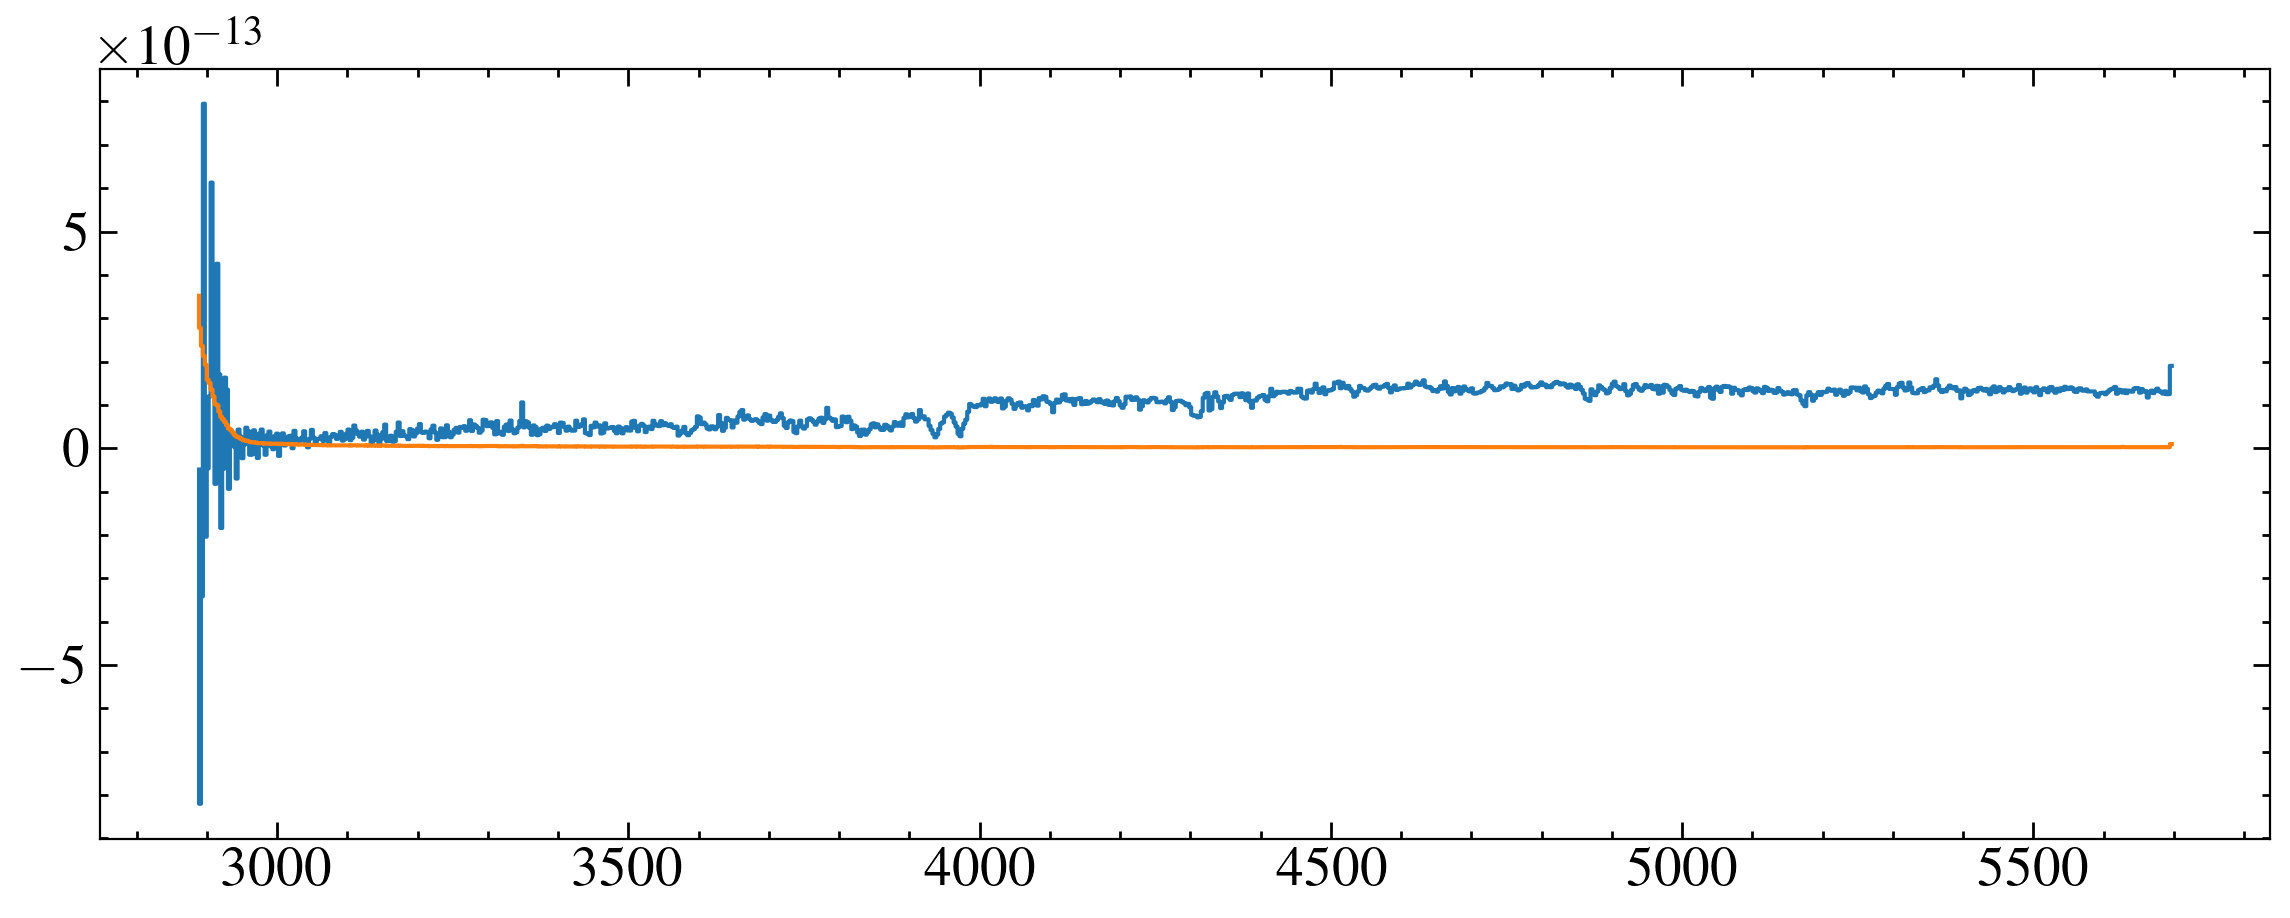

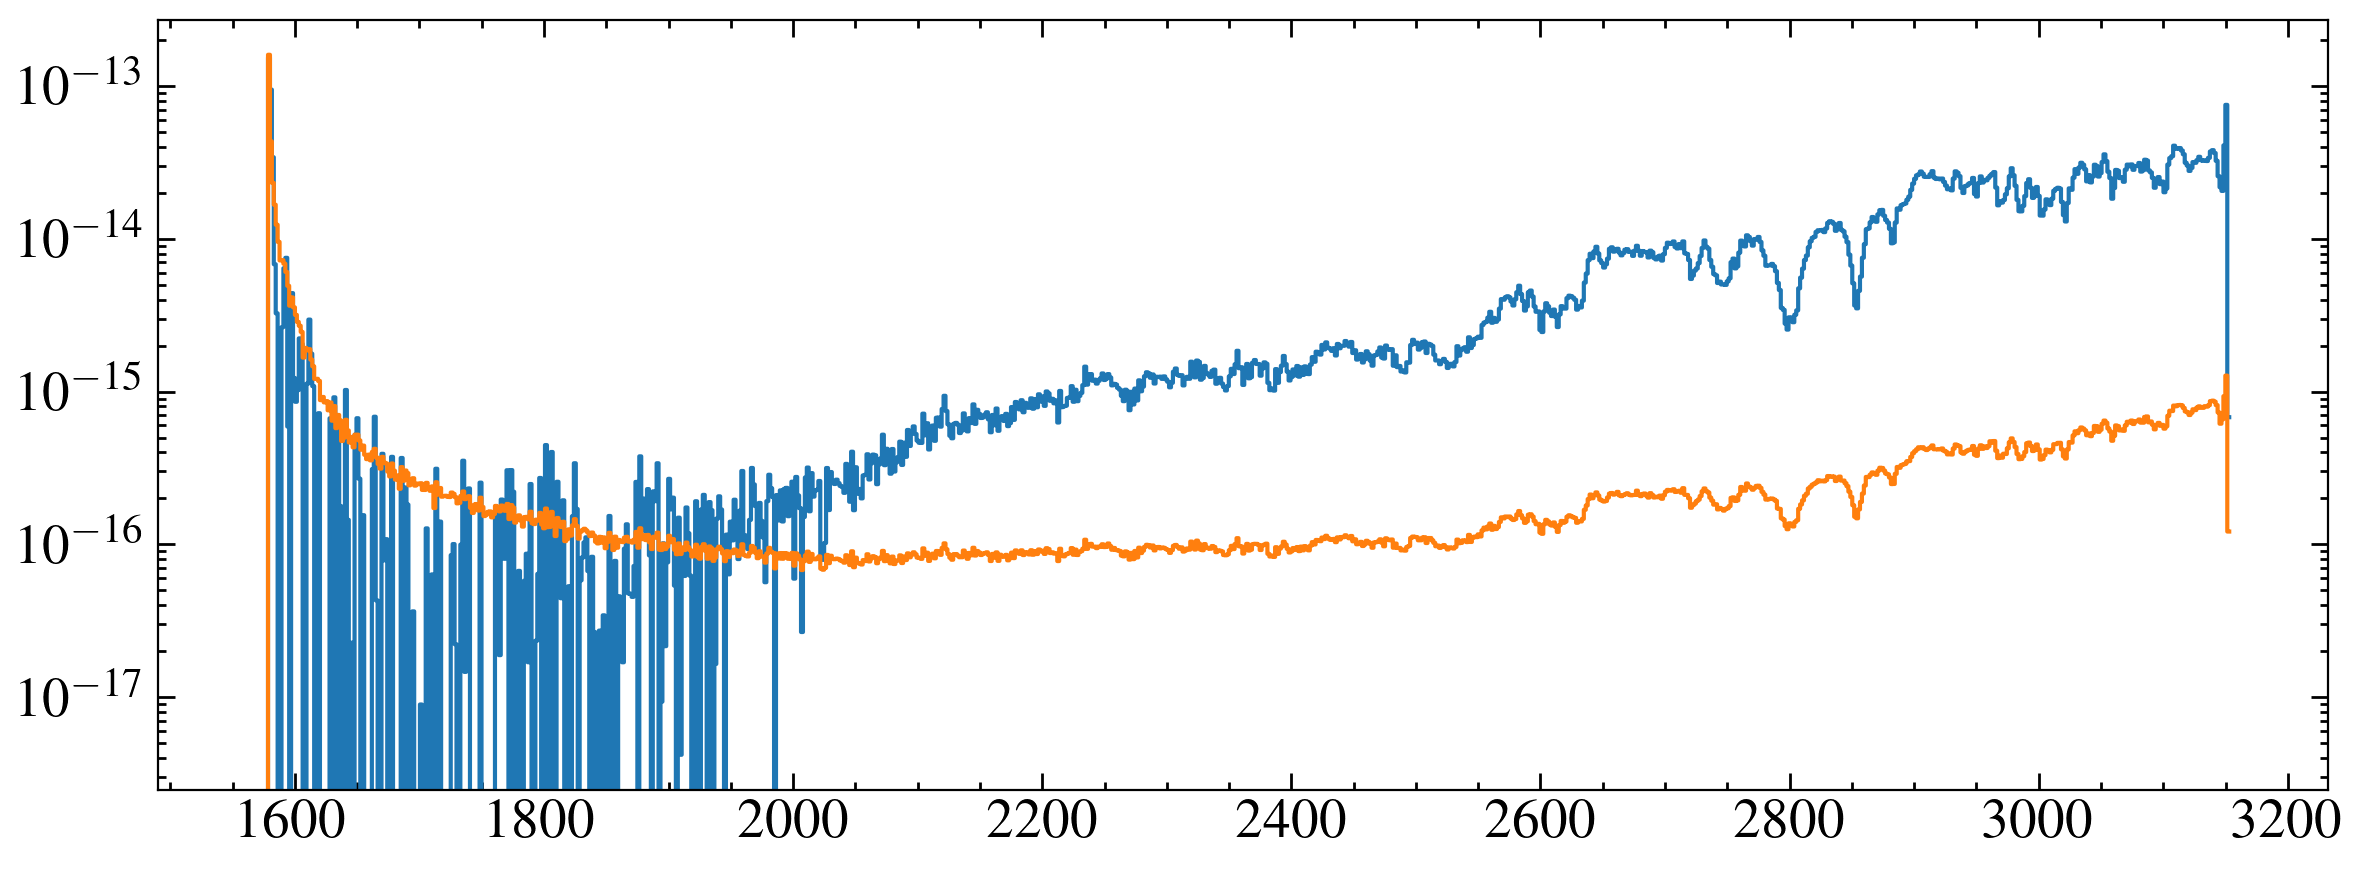

In [5]:
# plt.step(nuv['WAVELENGTH'], nuv['FLUX'])
# plt.step(nuv['WAVELENGTH'], nuv['ERROR'])
plt.step(opt['WAVELENGTH'], opt['FLUX'], zorder=-1)
plt.step(opt['WAVELENGTH'], opt['ERROR'])
# plt.xscale('log')
# plt.yscale('log')
# plt.xlim(3300, 3500)
# plt.ylim(0, 1.5e-13)
plt.show()
plt.step(nuv['WAVELENGTH'], nuv['FLUX'])
plt.step(nuv['WAVELENGTH'], nuv['ERROR'])
# plt.xscale('log')
plt.yscale('log')

In [6]:
nw, nf, ne = nuv['WAVELENGTH'],  nuv['FLUX'], nuv['ERROR']
nmask = (nw > 1980) & (nf > 0) & (nw < 3140) & (nf/ne >1)
nw, nf, ne = nw[nmask], nf[nmask], ne[nmask]
ow, of, oe = opt['WAVELENGTH'], opt['FLUX'], opt['ERROR']
omask = (ow > 3050) & (ow < 3345) | (ow > 3355) &  (ow < 5650)
ow, of, oe = ow[omask], of[omask], oe[omask]

/home/david/anaconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


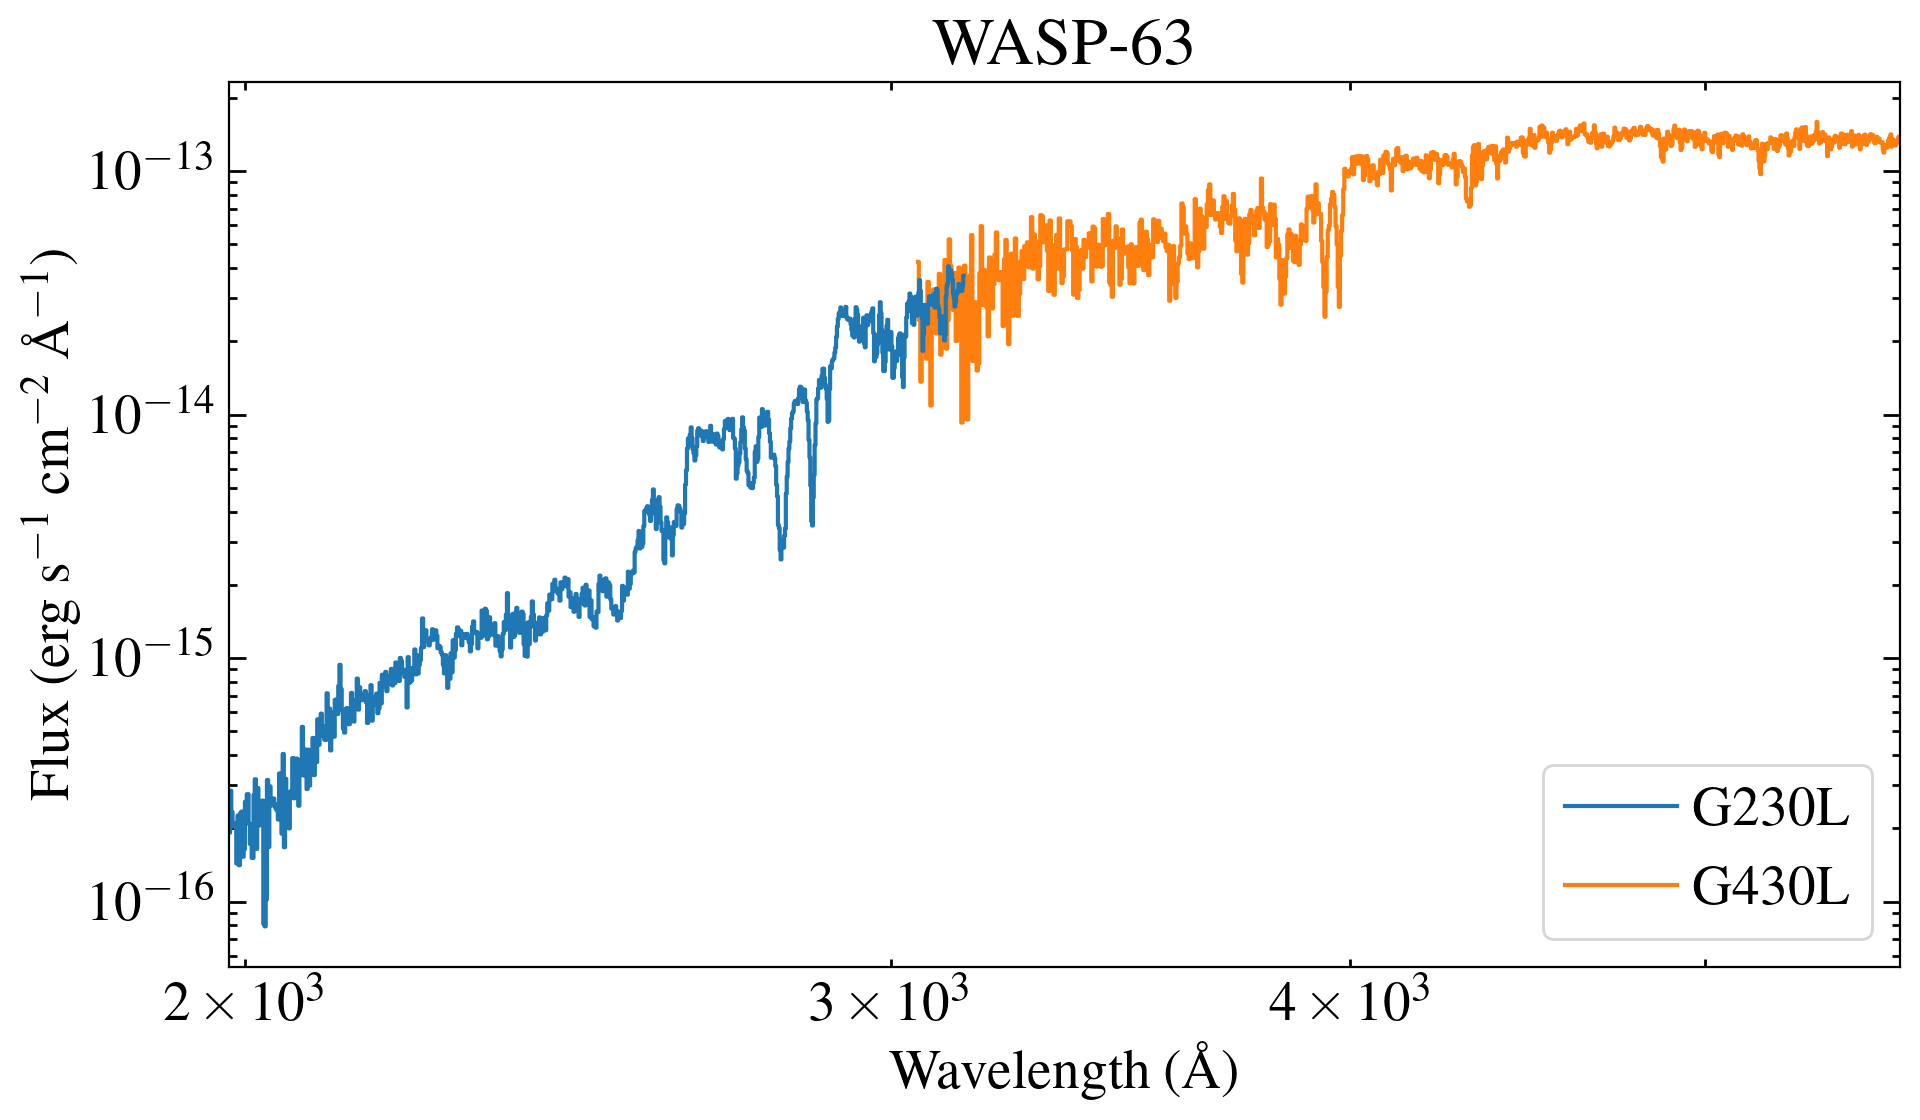

In [7]:
plt.figure(figsize=(10, 6))
plt.step(nw, nf, where='mid', label= 'G230L')
# plt.step(nw, ne, where='mid', label= 'G230L')
plt.step(ow, of, where='mid', label='G430L', zorder=-1)
# plt.xlim(3200, 3400)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
plt.legend(frameon=True, loc=4)
plt.title('WASP-63')
plt.xlim(1980, 5650)
plt.tight_layout()


In [8]:
import prepare_phoenix_svo as pp


Params from Allison's table

In [9]:
G = const.G
M = const.M_sun.to(u.kg)
R = const.R_sun.to(u.m)
mass = 1.1
# teff = 5715
teff = 5550
teff_e = 100
# radius = 1.79
radius = 1.76
distance = 288.94
save_path = 'models/'
star = 'Wasp_63'
g = ((G*mass*M)/(radius*R)**2).to(u.cm/u.s**2)
repo = '/media/david/2tb_ext_hd/hddata/mega_muscles/data-vacuum/'

star_params = {'Teff': teff, 'logg': np.log10(g.value), 'FeH': 0.00, 'aM': 0, 'Radius':radius*u.R_sun, 'Distance':distance*u.pc, 'Teff_e':teff_e}
# pw, pf, pe = pp.make_phoenix_spectrum(star, save_path, repo, star_params, save_ecsv=True, plot=False, make_error=True)
normfac = ((radius*R)/(distance*u.pc.to(u.m)))**2

pdata = Table.read('models/Wasp_63_phoenix_interpolated.ecsv')
pw, pf, pe = pdata['WAVELENGTH'], pdata['FLUX'], pdata['ERROR']

501.0
45.7143701012358


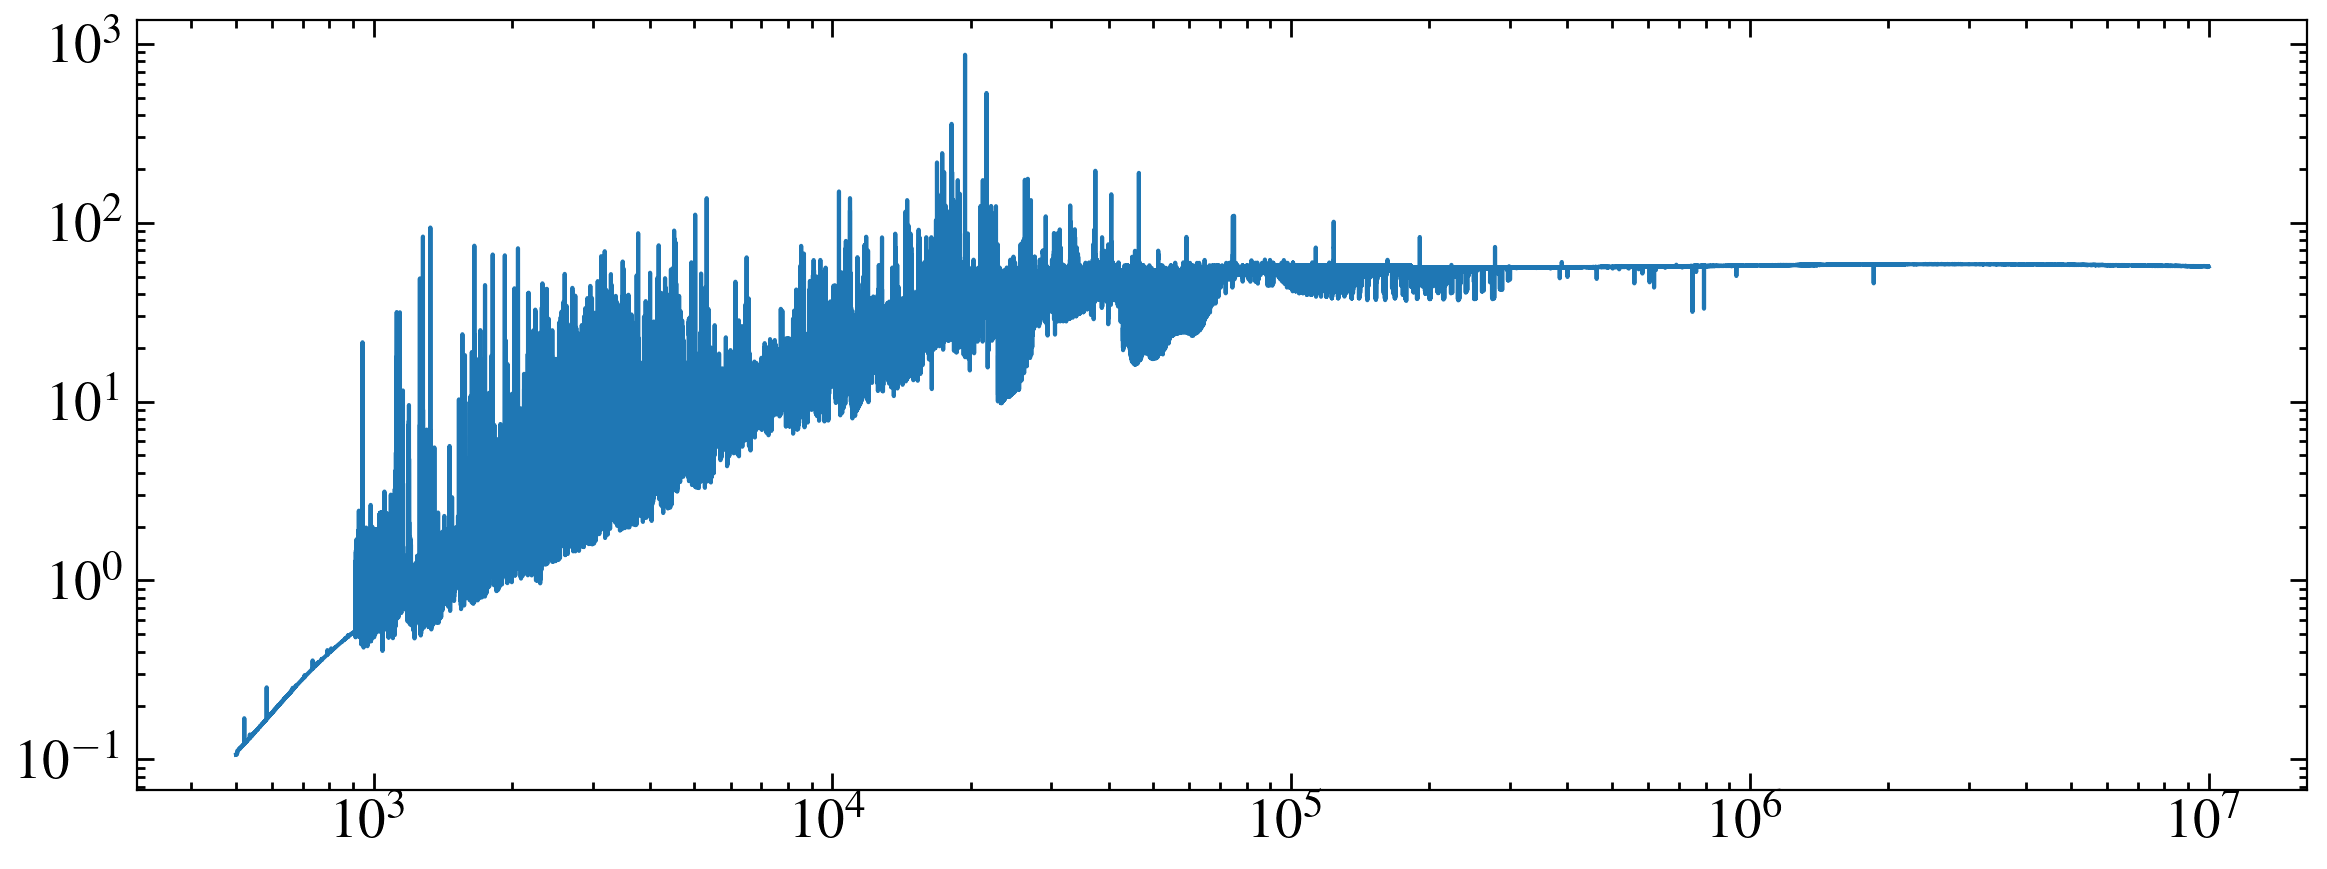

In [10]:
# plt.plot(pw, pf)
# plt.plot(pw, pe)

# plt.xscale('log')
# plt.yscale('log')

plt.plot(pw, pf/pe)
plt.yscale('log')
plt.xscale('log')

print(min(pw[pf/pe >0]))

print(np.median(pf/pe))

In [11]:
from astropy.convolution import convolve_fft
from astropy.convolution import Gaussian1DKernel

def smear(w,f, R, w_sample=1):
    '''
    Smears a model spectrum with a gaussian kernel to the given resolution, R.
    Adapeted from https://github.com/spacetelescope/pysynphot/issues/78

    Parameters
    -----------

    w,f:  spectrum to smear

    R: int
        The resolution (dL/L) to smear to

    w_sample: int
        Oversampling factor for smoothing

    Returns
    -----------

    sp: PySynphot Source Spectrum
        The smeared spectrum
    '''

    # Save original wavelength grid and units
    w_grid = w
    

    # Generate logarithmic wavelength grid for smoothing
    w_logmin = np.log10(np.nanmin(w_grid))
    w_logmax = np.log10(np.nanmax(w_grid))
    n_w = np.size(w_grid)*w_sample
    w_log = np.logspace(w_logmin, w_logmax, num=n_w)

    # Find stddev of Gaussian kernel for smoothing
    R_grid = (w_log[1:-1]+w_log[0:-2])/(w_log[1:-1]-w_log[0:-2])/2
    sigma = np.median(R_grid)/R
    if sigma < 1:
        sigma = 1

    # Interpolate on logarithmic grid
    f_log = np.interp(w_log, w_grid, f)

    # Smooth convolving with Gaussian kernel
    gauss = Gaussian1DKernel(stddev=sigma)
    f_conv = convolve_fft(f_log, gauss)

    # Interpolate back on original wavelength grid
    f_sm = np.interp(w_grid, w_log, f_conv)

    # Write smoothed spectrum back into Spectrum object
    return w_grid, f_sm

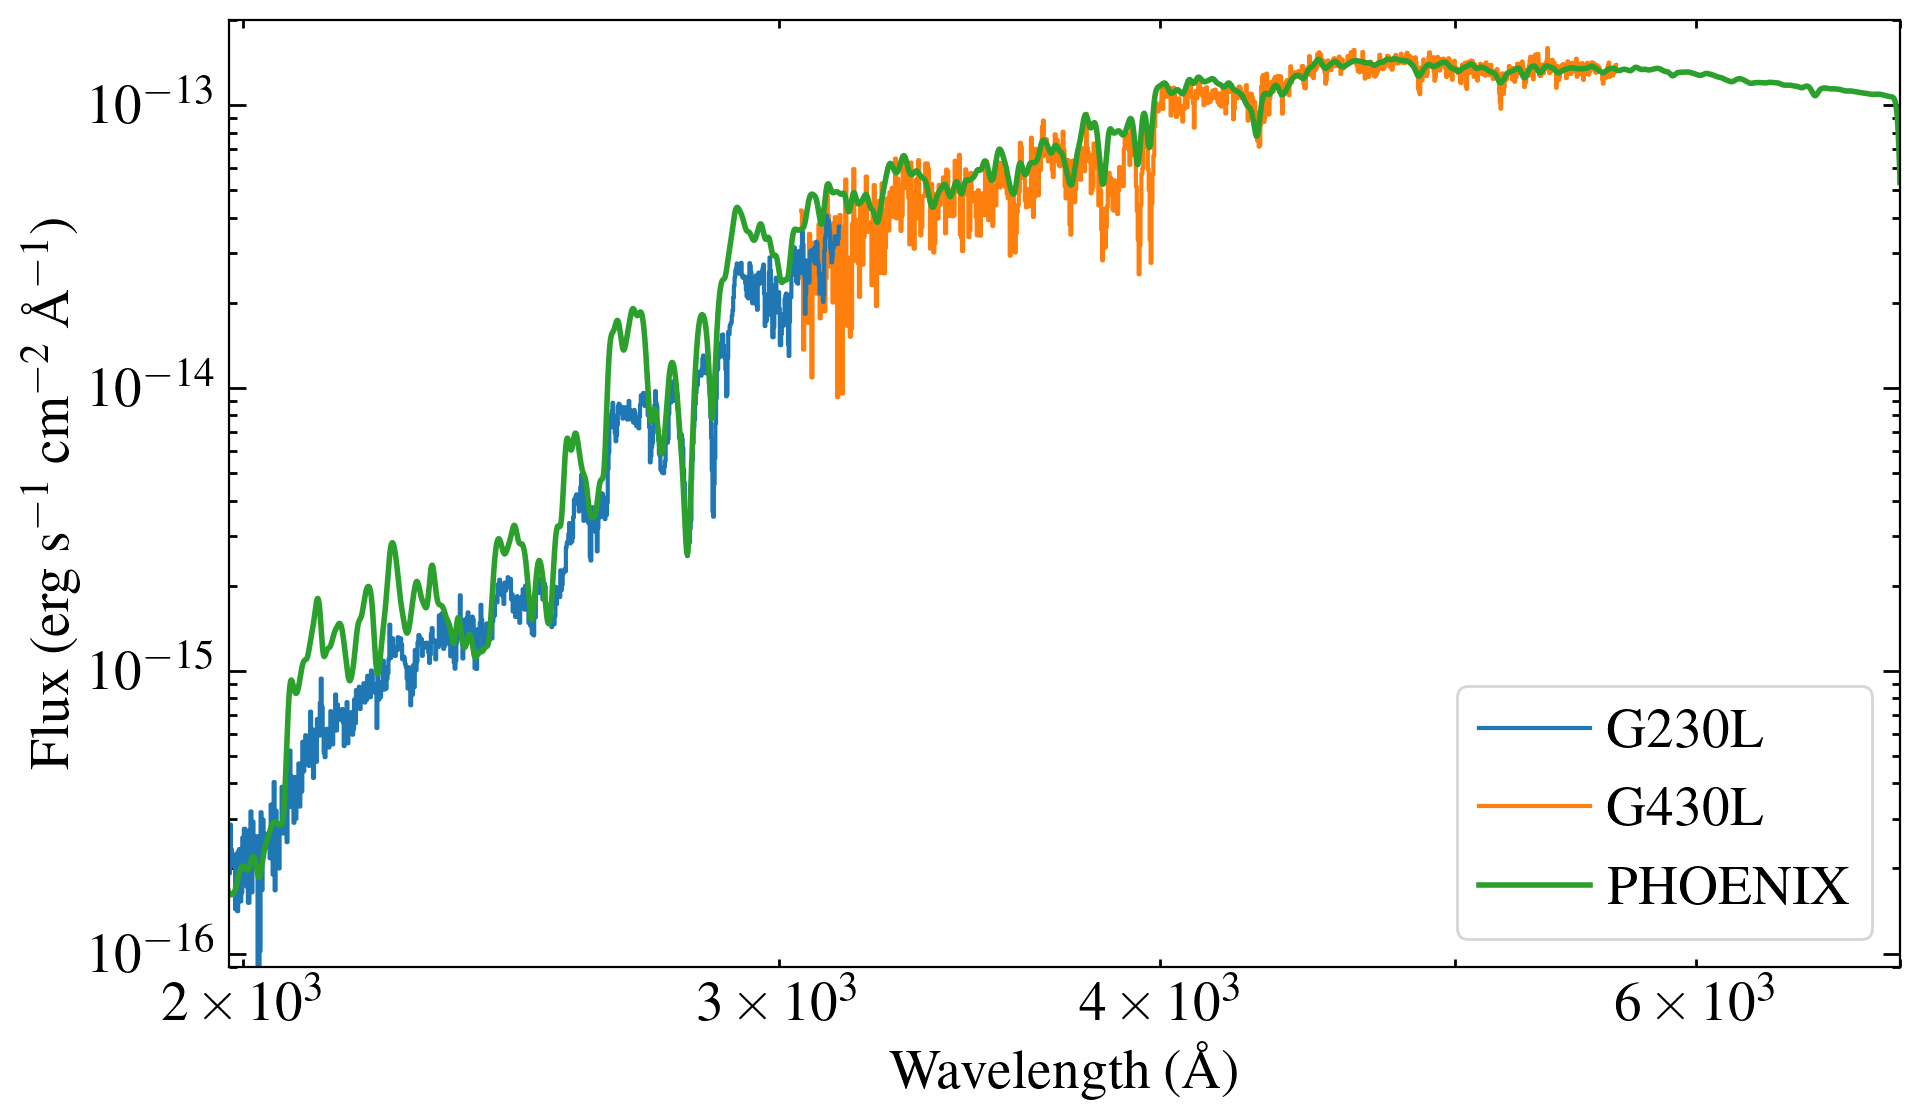

In [12]:
pmask = (pw > 1900) & (pw < 7000)
pwi, pfi = pw[pmask], pf[pmask]*normfac
pwi, pfi = smear(pwi, pfi, 500)
plt.figure(figsize=(10, 6))
plt.step(nw, nf, where='mid', label= 'G230L')
# plt.step(nw, ne, where='mid', label= 'G230L')
plt.step(ow, of, where='mid', label='G430L', zorder=-1)
# plt.xlim(3200, 3400)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
plt.plot(pwi, pfi, lw=2, label= 'PHOENIX')
plt.legend(frameon=True, loc=4)

# plt.title('WASP-63')
plt.xlim(1980, 7000)
plt.ylim(9e-17, 2e-13)
plt.tight_layout()


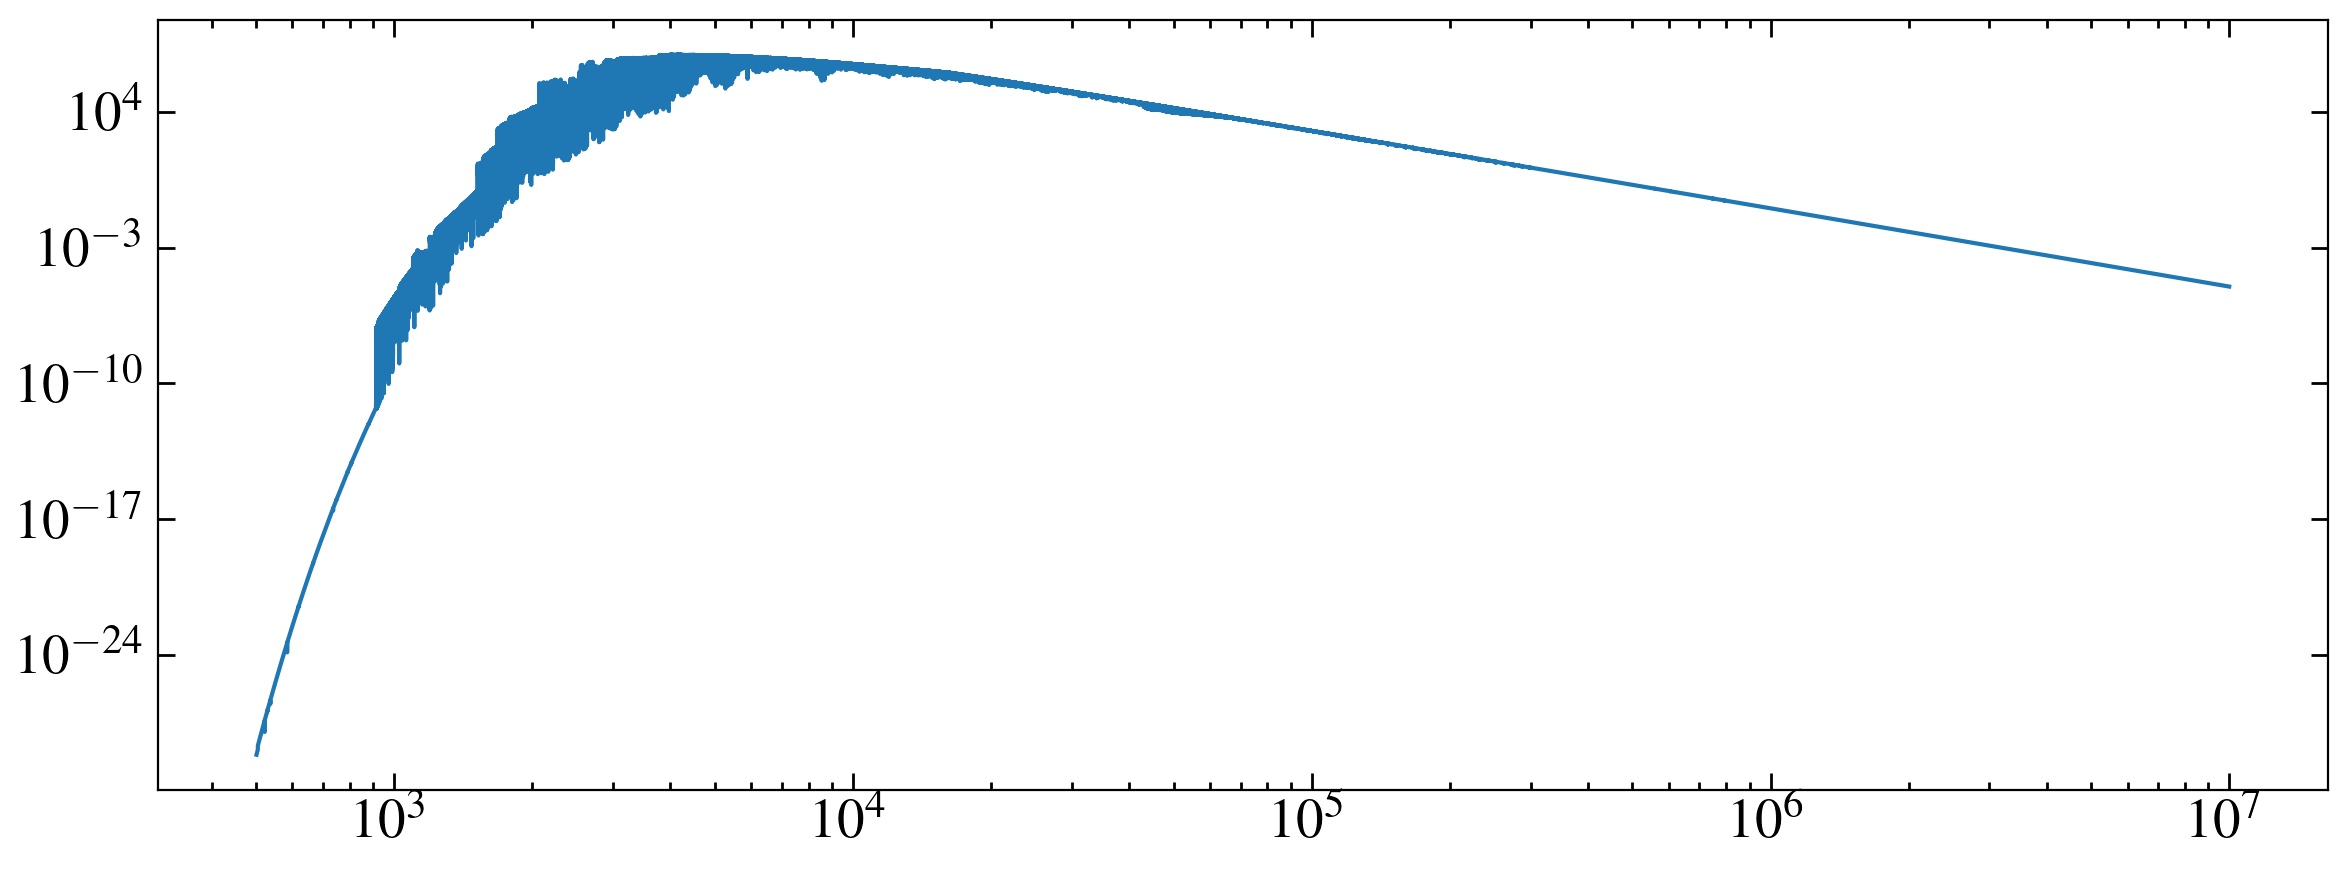

In [13]:
plt.plot(pw, pf)
plt.xscale('log')
plt.yscale('log')

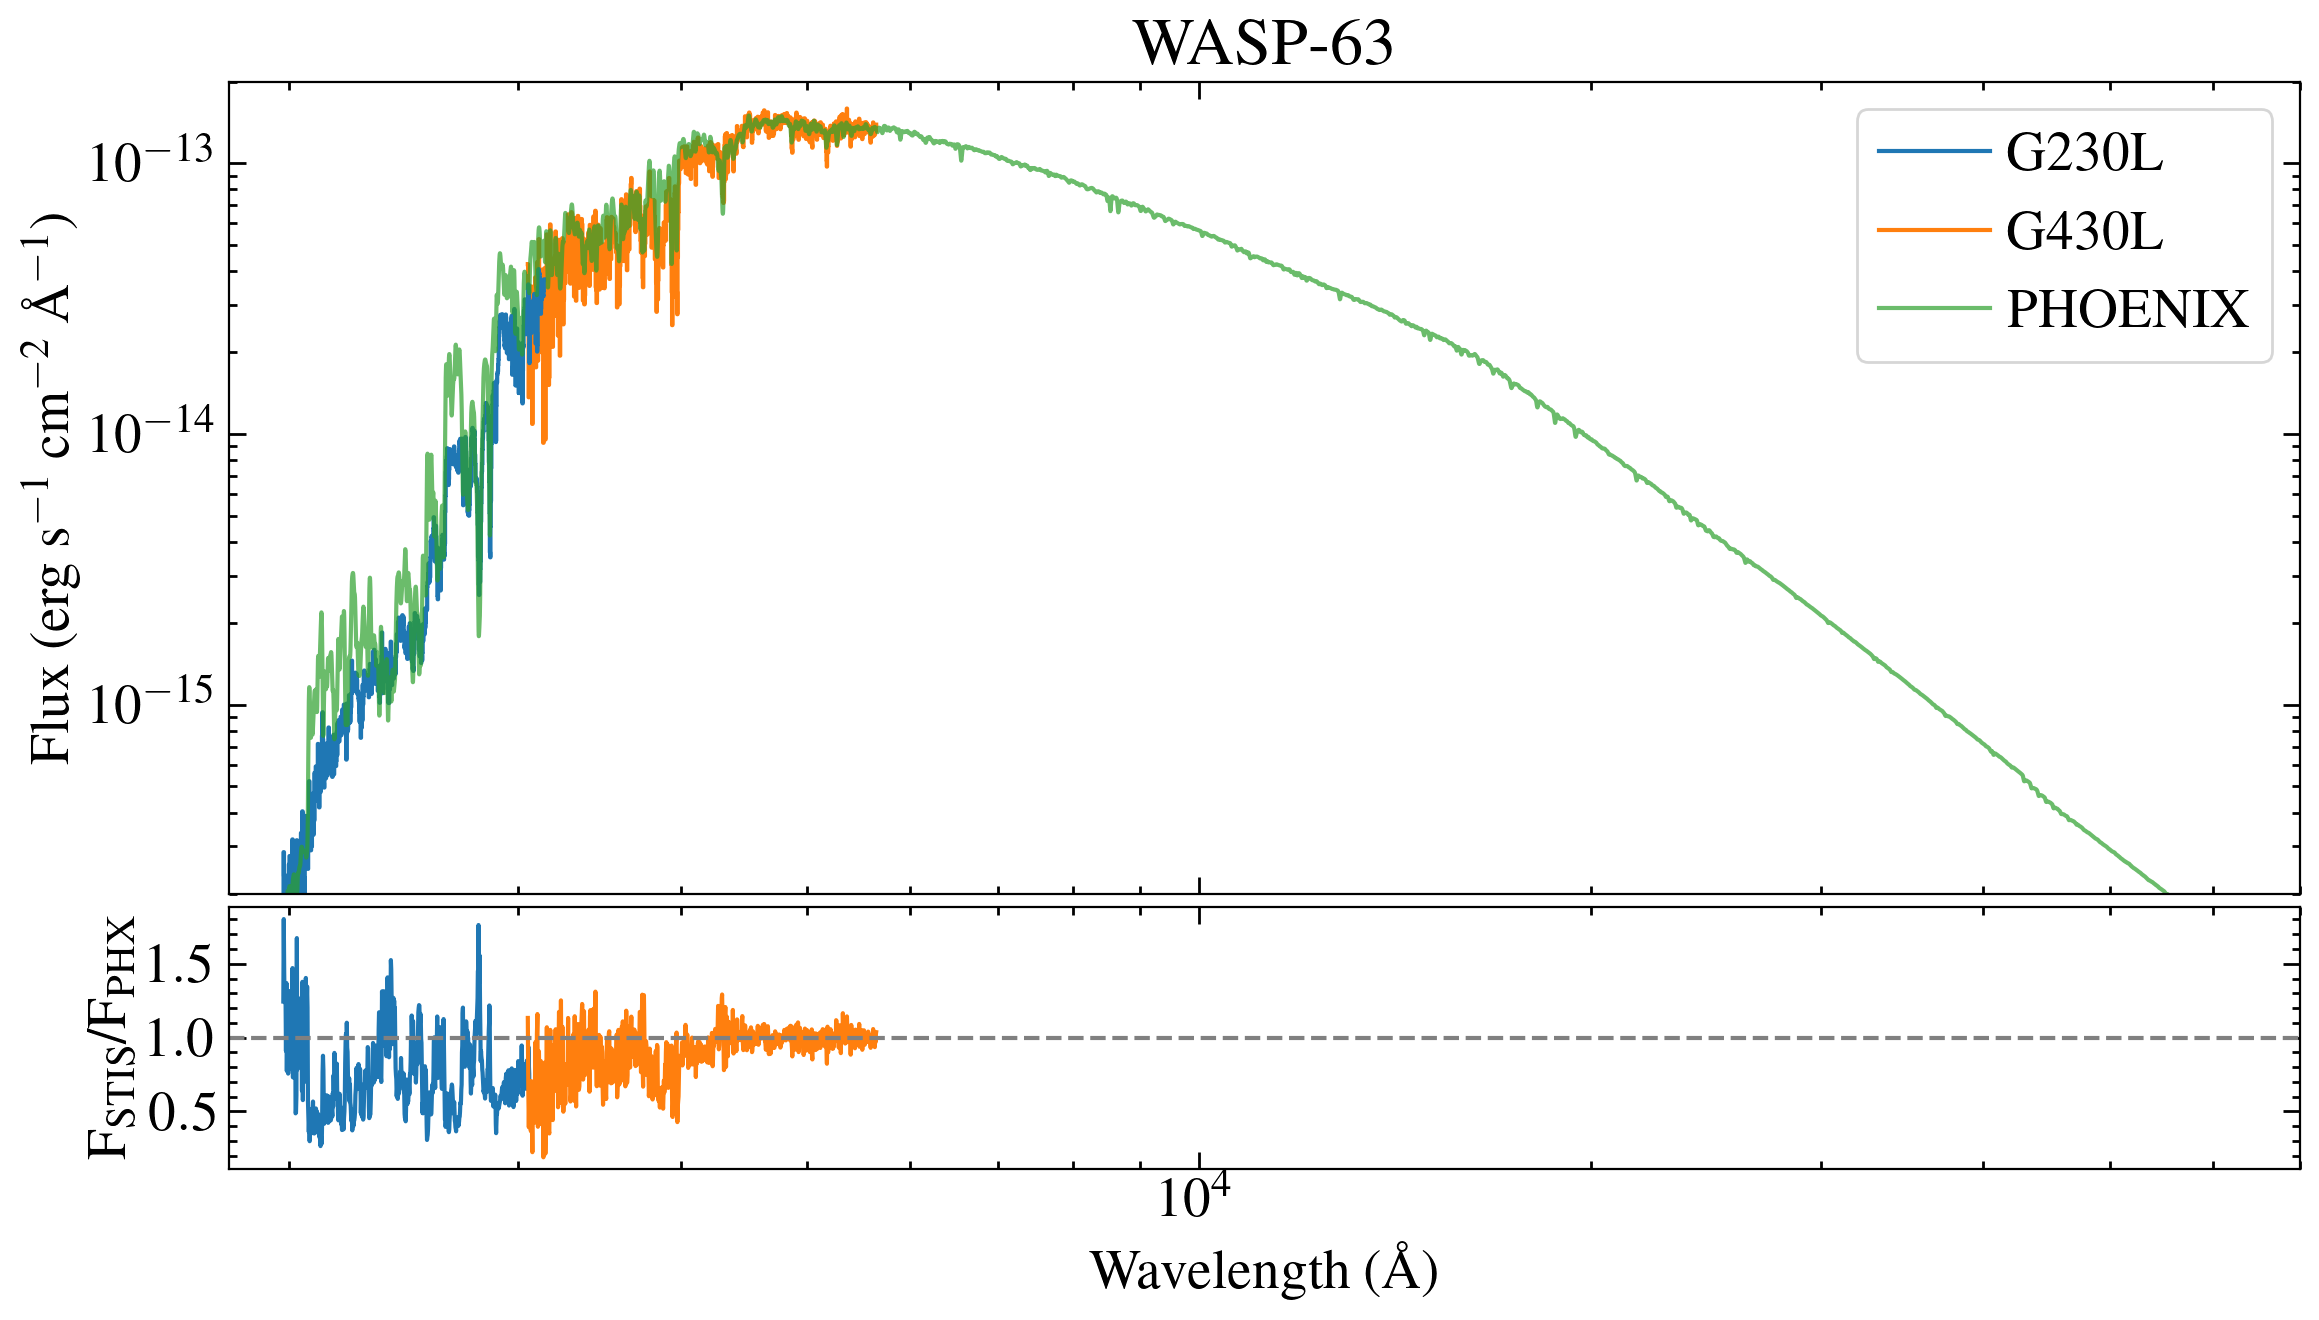

In [14]:
pwi, pfi = smear(pw, pf, 1000)
pmask = (pwi > 1600) & (pwi < 100000)
pwi, pfi = pwi[pmask], pfi[pmask]*normfac

fig, axes = plt.subplots(figsize=(12,7))
gs = GridSpec(4, 1, figure=fig)
plt.subplot(gs[0:3])
plt.step(nw, nf, where='mid', label= 'G230L')
# plt.step(nw, ne, where='mid', label= 'G230L')
plt.step(ow, of, where='mid', label='G430L', zorder=-1)
# plt.xlim(3200, 3400)
plt.xscale('log')
plt.yscale('log')

plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
plt.plot(pwi, pfi, label= 'PHOENIX', alpha=0.7)
plt.legend(frameon=True, loc=1)
plt.xticks(visible=False)
plt.title('WASP-63')
plt.xlim(1800, 70000)
plt.ylim(2e-16, 2e-13)

plt.subplot(gs[3:])
pwn, pfn = pwi[(pwi > nw[0]) & (pwi < nw[-1])], pfi[(pwi > nw[0]) & (pwi < nw[-1])]
pfn = interp1d(pwn, pfn, fill_value='extrapolate')(nw)
plt.plot(nw, nf/pfn)
pwo, pfo = pwi[(pwi > ow[0]) & (pwi < ow[-1])], pfi[(pwi > ow[0]) & (pwi < ow[-1])]
pfo = interp1d(pwo, pfo, fill_value='extrapolate')(ow)
plt.plot(ow, of/pfo)
plt.axhline(1, ls='--', c='0.5')
plt.xlim(1800, 70000)
plt.xscale('log')

plt.xlabel('Wavelength (\AA)')
plt.ylabel('F$_{\mathrm{STIS}}$/F$_{\mathrm{PHX}}$')
plt.tight_layout()
plt.subplots_adjust(hspace=0.05)
plt.savefig('plots/WASP-63_stis_v_phoenix.png', facecolor= 'w')

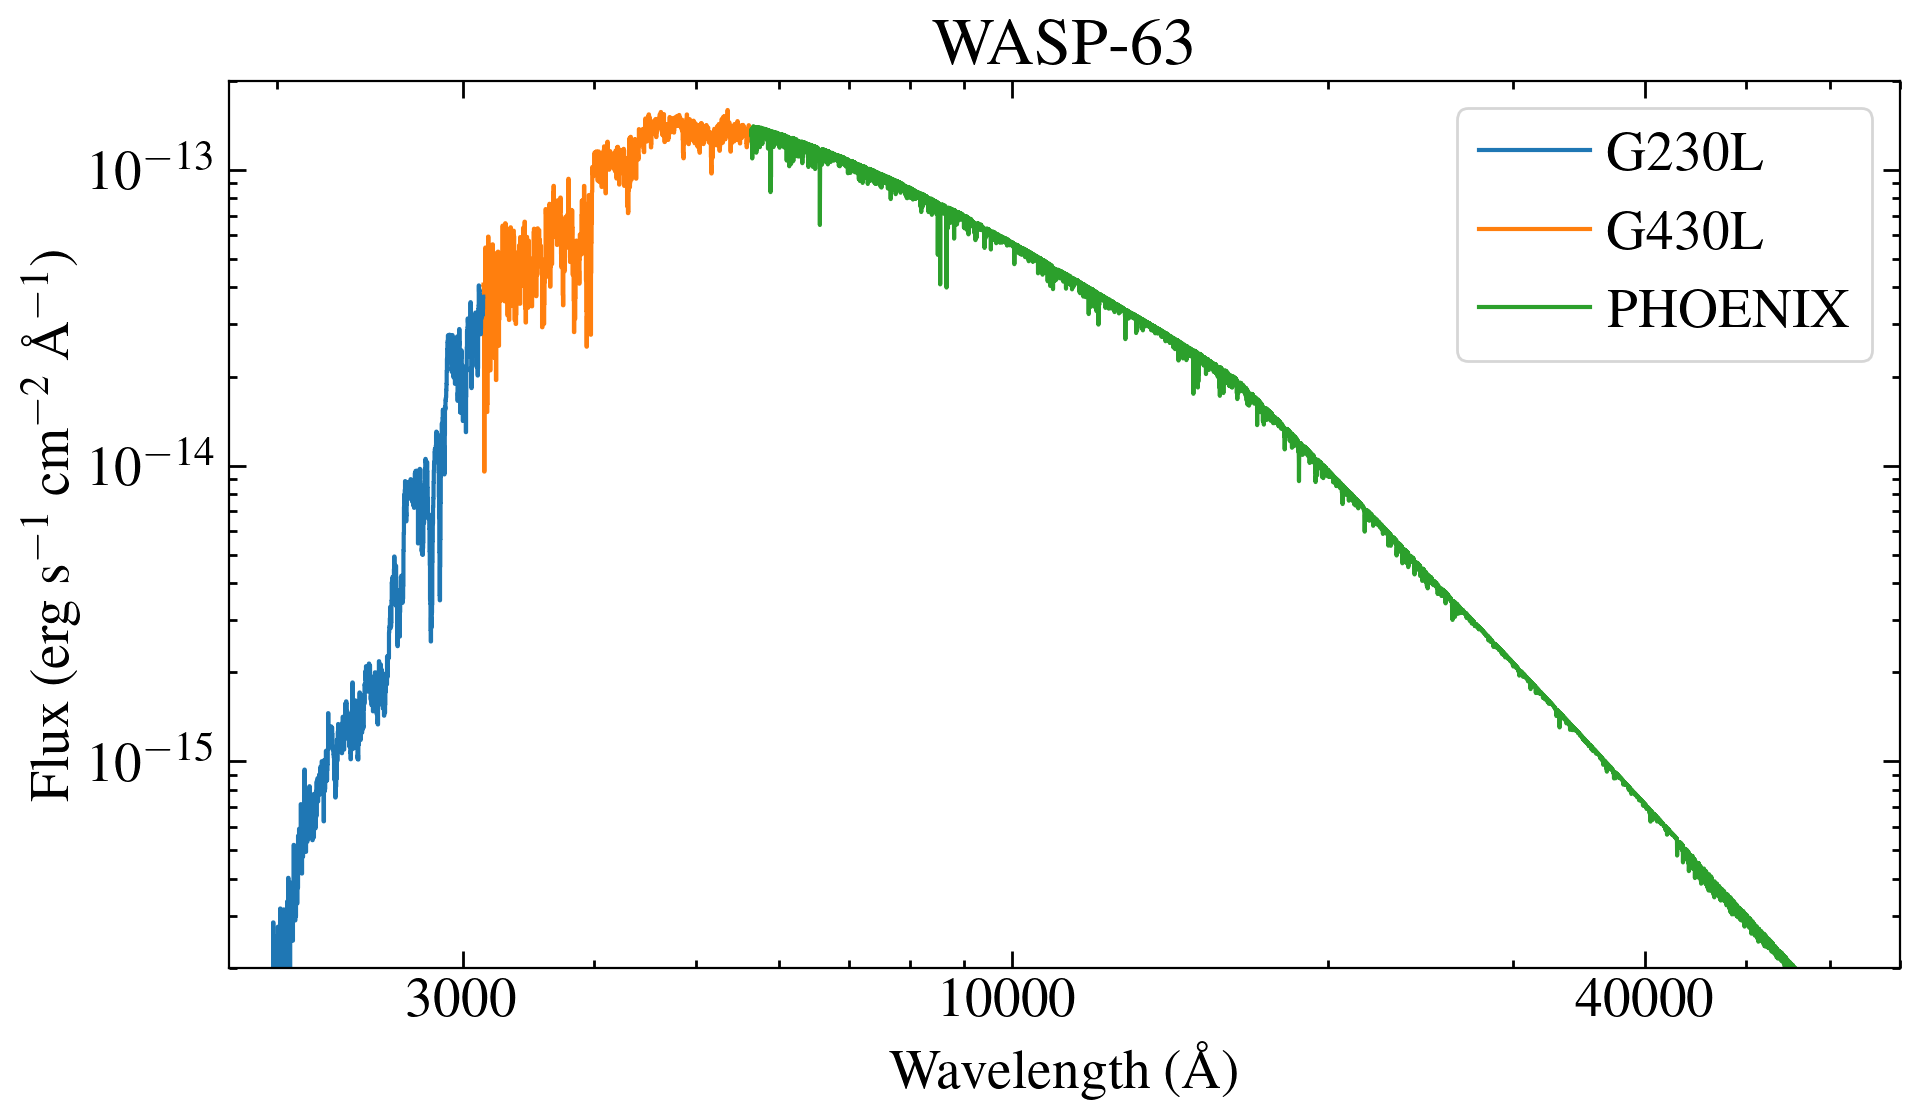

In [15]:
pwi, pfi = smear(pw, pf, 10000)
pmask = (pwi > 5650) & (pwi < 100000)
pwi, pfi = pwi[pmask], pfi[pmask]*normfac

fig, axes = plt.subplots(figsize=(10,6))
# gs = GridSpec(4, 1, figure=fig)
# plt.subplot(gs[0:3])
plt.step(nw, nf, where='mid', label= 'G230L')
# plt.step(nw, ne, where='mid', label= 'G230L')
plt.step(ow[(ow > nw[-1])], of[(ow > nw[-1])], where='mid', label='G430L', zorder=-1)
# plt.xlim(3200, 3400)
plt.xscale('log')
plt.yscale('log')

plt.plot(pwi, pfi, label= 'PHOENIX')
# plt.plot(pw[pw> 5650], pf[pw> 5650]*normfac, label= 'PHOENIX')
plt.legend(frameon=True, loc=1)
plt.title('WASP-63')
plt.xlim(1800, 70000)
plt.ylim(2e-16, 2e-13)
plt.xticks((3000, 10000, 40000), (3000, 10000, 40000))


plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')

plt.tight_layout()
plt.subplots_adjust(hspace=0.05)
plt.savefig('plots/WASP-63_ql.png', facecolor= 'w')

In [16]:
# import mplcyberpunk
# plt.style.use('cyberpunk')


In [17]:
# pwi, pfi = smear(pw, pf, 10000)
# pmask = (pwi > 5650) & (pwi < 100000)
# pwi, pfi = pwi[pmask], pfi[pmask]*normfac

# fig, axes = plt.subplots(figsize=(10,6))
# # gs = GridSpec(4, 1, figure=fig)
# # plt.subplot(gs[0:3])
# plt.step(nw, nf, where='mid', label= 'G230L', c='C4')
# # plt.step(nw, ne, where='mid', label= 'G230L')
# plt.step(ow[(ow > nw[-1])], of[(ow > nw[-1])], where='mid', label='G430L', zorder=-1, c='C4')
# # plt.xlim(3200, 3400)
# plt.xscale('log')
# plt.yscale('log')

# plt.plot(pwi, pfi, label= 'PHOENIX', c='C4')
# # plt.plot(pw[pw> 5650], pf[pw> 5650]*normfac, label= 'PHOENIX')
# # plt.legend(frameon=True, loc=1)
# plt.title('WASP-63')
# plt.xlim(1800, 70000)
# plt.ylim(2e-16, 6e-13)
# plt.xticks((3000, 10000, 40000), (3000, 10000, 40000))

# liney = 2.5e-13
# lineb = 0.5e-13
# linescale = 1.2

# plt.errorbar(np.array([1900., nw[-1]]),np.array([liney, liney]),yerr=np.array([[lineb, lineb], [0.,0]]), c='C0')
# plt.errorbar(np.array([ow[(ow > nw[-1])][0]+50, pwi[0]]),np.array([liney, liney]),yerr=np.array([[lineb, lineb], [0.,0]]), c='C0')
# plt.errorbar(np.array([pwi[0]+100, 60000.]),np.array([liney, liney]),yerr=np.array([[lineb, lineb], [0.,0]]), c='C0')

# plt.annotate('G230L', (2500, liney*linescale, ), ha='center')
# plt.annotate('G430L', (4300, liney*linescale, ), ha='center')
# plt.annotate('PHOENIX', (18000, liney*linescale, ), ha='center')


# mplcyberpunk.add_glow_effects()
# plt.xlabel('Wavelength (\AA)')
# plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')

# plt.tight_layout()
# # plt.subplots_adjust(hspace=0.05)
# plt.savefig('plots/WASP-63_cp.png', dpi=150)
# plt.savefig('plots/WASP-63_cp.pdf')

NB WASP-96 has almost identical Teff to WASP-63, but is futher away. Can scale WASP-63 spectrum to plan a ddt.

In [18]:
d_63 = 290.684 #pc
d_96 = 352.464

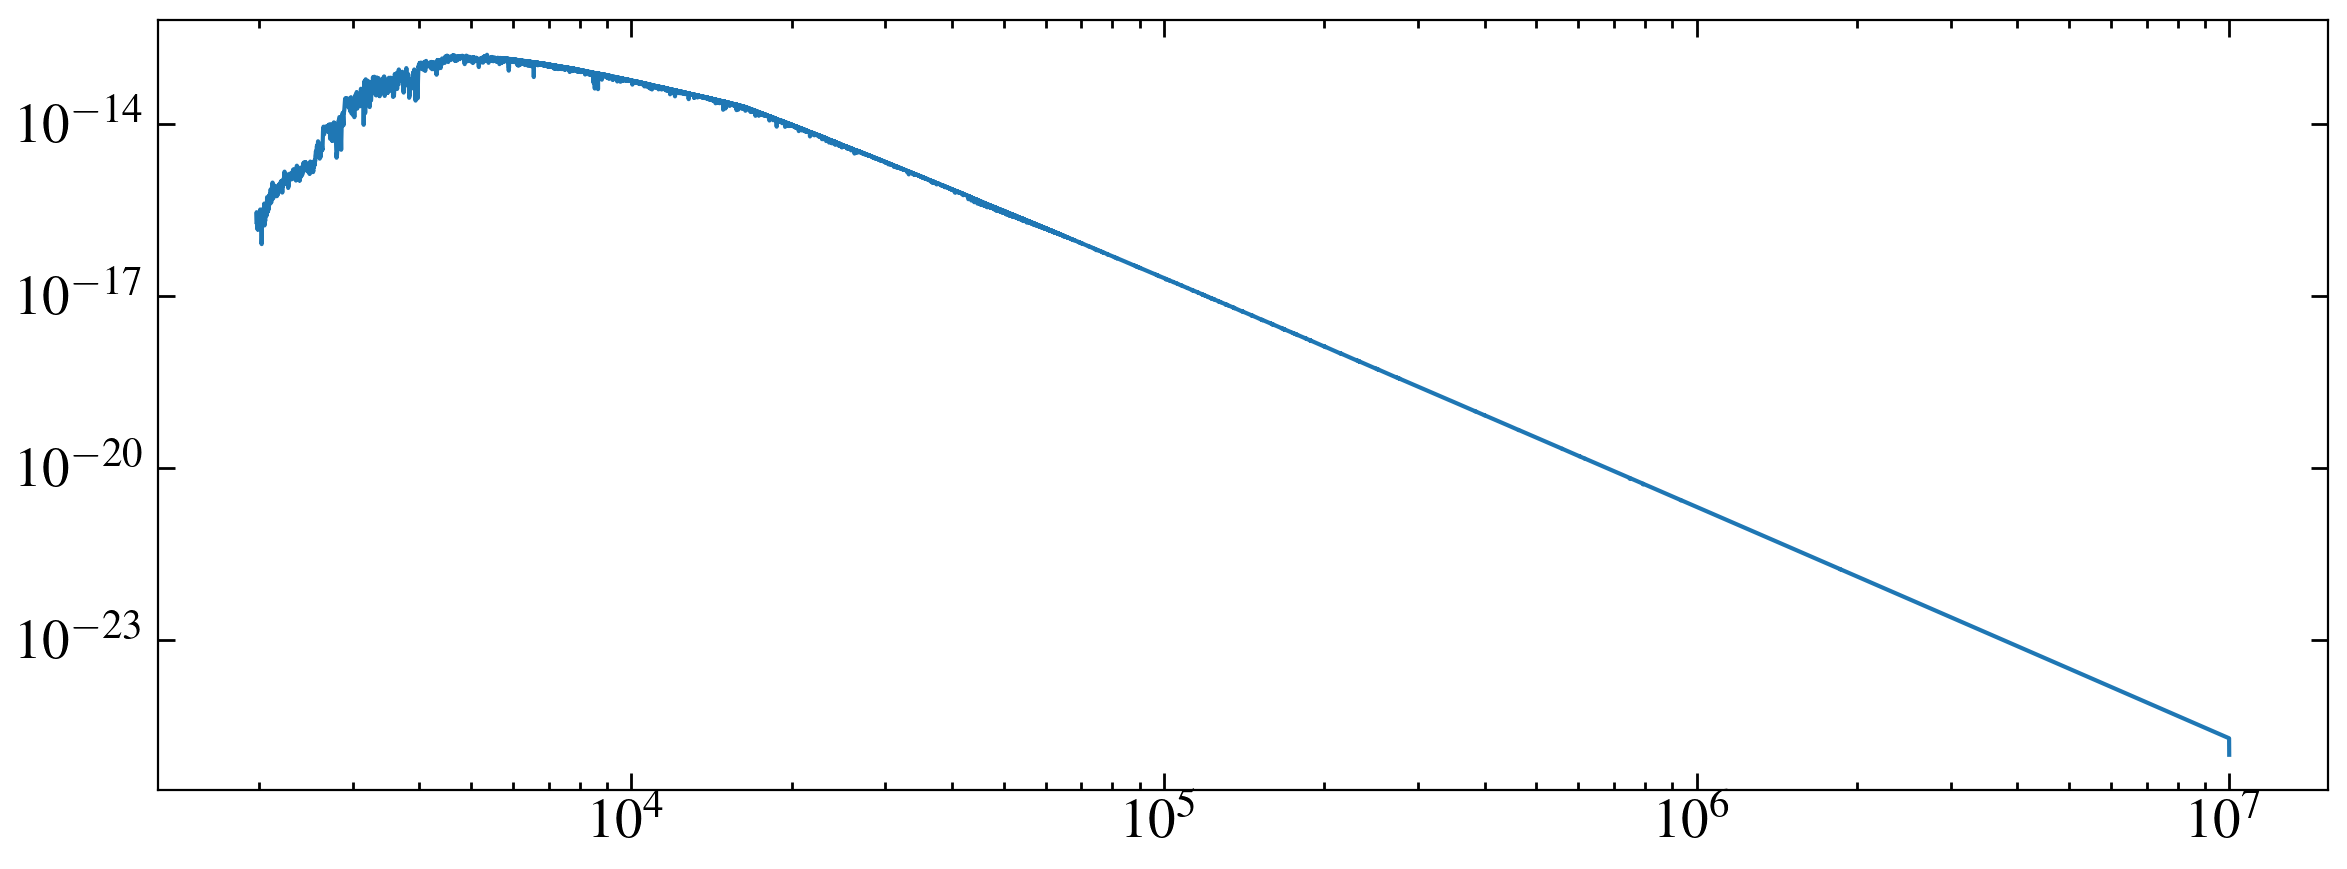

In [19]:
pwi, pfi = smear(pw, pf, 10000)
pmask = (pwi > 5650) #& (pwi < 100000)
pwi, pfi = pwi[pmask], pfi[pmask]*normfac

w_full = np.concatenate((nw, ow[(ow > nw[-1])], pwi))
f_full = np.concatenate((nf, of[(ow > nw[-1])], pfi.value))
plt.plot(w_full, f_full)
plt.yscale('log')
plt.xscale('log')

In [20]:
savdat = Table([w_full, f_full], names=['WAVELENGTH', 'FLUX'])
ascii.write(savdat, 'draft_seds/wasp-63_v1_sed.ecsv', format='ecsv', overwrite=True)


In [21]:
# fig, axes = plt.subplots(figsize=(10,6))


# plt.plot(w_full, f_full, label = 'WASP-63', c='C4')
# plt.plot(w_full, f_full*(d_63/d_96)**2, label = 'WASP-96 estimate', c='C0', zorder=-1)
# plt.yscale('log')
# plt.xscale('log')


# plt.xlim(1800, 70000)
# plt.ylim(2e-16, 4e-13)
# plt.xticks((3000, 10000, 40000), (3000, 10000, 40000))

# liney = 2.5e-13
# lineb = 0.5e-13
# linescale = 1.2

# # plt.errorbar(np.array([1900., nw[-1]]),np.array([liney, liney]),yerr=np.array([[lineb, lineb], [0.,0]]), c='C0')
# # plt.errorbar(np.array([ow[(ow > nw[-1])][0]+50, pwi[0]]),np.array([liney, liney]),yerr=np.array([[lineb, lineb], [0.,0]]), c='C0')
# # plt.errorbar(np.array([pwi[0]+100, 60000.]),np.array([liney, liney]),yerr=np.array([[lineb, lineb], [0.,0]]), c='C0')

# # plt.annotate('G230L', (2500, liney*linescale, ), ha='center')
# # plt.annotate('G430L', (4300, liney*linescale, ), ha='center')
# # plt.annotate('PHOENIX', (18000, liney*linescale, ), ha='center')

# plt.legend()

# mplcyberpunk.add_glow_effects()
# plt.xlabel('Wavelength (\AA)')
# plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')

# plt.tight_layout()
# plt.savefig('plots/WASP-63_v96.png', dpi=150)
# # plt.savefig('plots/WASP-63_cp.pdf')

In [22]:
# savdat = Table([w_full, f_full*(d_63/d_96)**2], names=['WAVELENGTH', 'FLUX'])
# ascii.write(savdat, 'draft_seds/wasp-96_estimate_sed.ecsv', format='ecsv', overwrite=True)

savdat = Table([w_full[0:10000], f_full[0:10000]*(d_63/d_96)**2])
ascii.write(savdat, 'draft_seds/wasp-96_estimate_sed.txt', format='basic', overwrite=True)


In [23]:
# plt.plot(w_full[0:10000], f_full[0:10000]*(d_63/d_96)**2, label = 'WASP-96 estimate', c='C0', zorder=-1)

In [24]:
len(w_full)

1105016

20220921 adding the Sun as a proxy

In [25]:
sol_spec =  readsav('Solar-data.idlsav')
w_sol, f_sol = sol_spec['wave'][:,0]*10, sol_spec['flux'][:,0]*100

2.781681986760802e-16


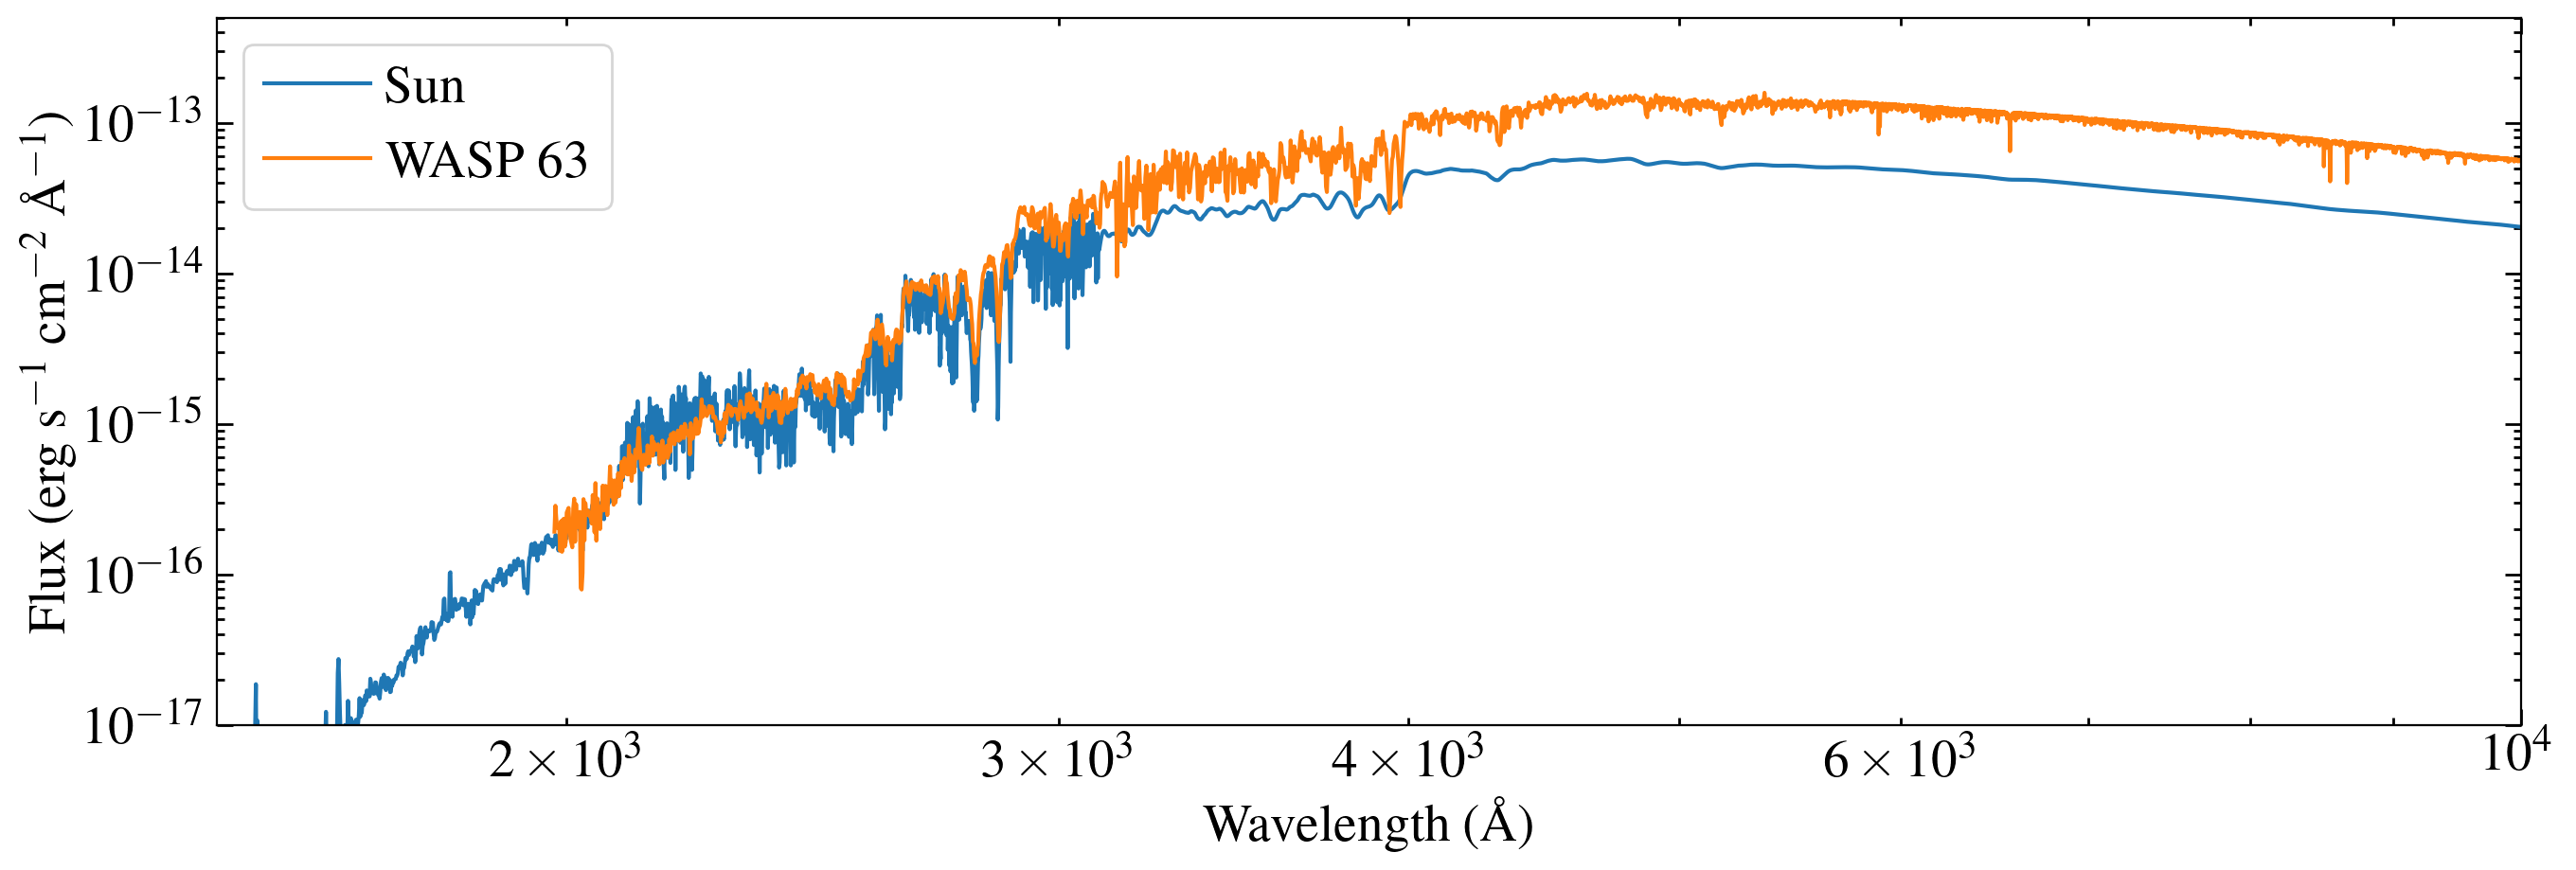

(0.0, 2e-15)

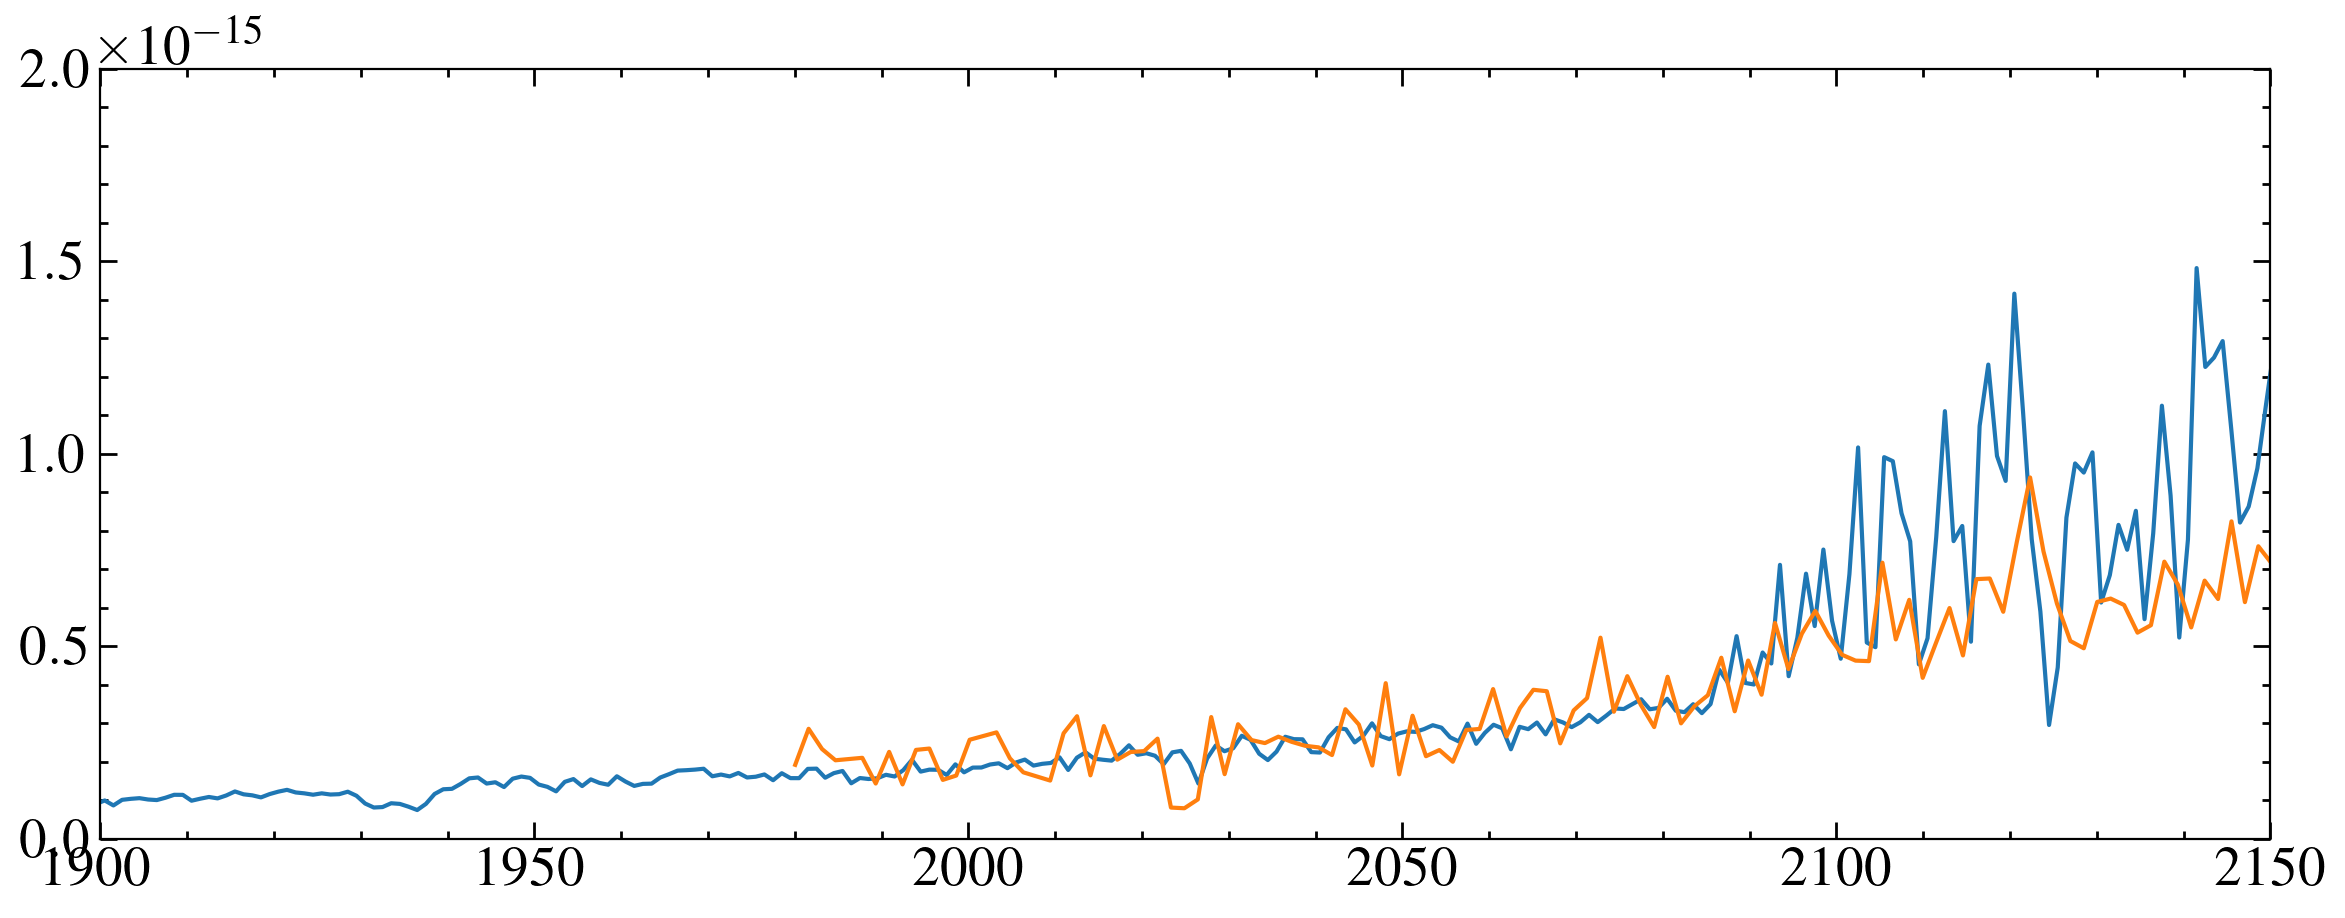

In [26]:
solscale= (((1*u.au).to(u.pc))/(d_63*u.pc))**2
print(solscale)

plt.plot(w_sol, f_sol*solscale, label='Sun')
plt.plot(w_full, f_full, label='WASP 63')
plt.yscale('log')
plt.xscale('log')
plt.xlim(1500, 10000)
plt.ylim(1e-17, 5e-13)

plt.legend(frameon=True)


plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')

plt.tight_layout()

plt.show()

plt.plot(w_sol, f_sol*solscale)
plt.plot(w_full, f_full)
# plt.yscale('log')
# plt.xscale('log')
# plt.xlim(1000, 10000)
plt.xlim(1900, 2150)
plt.ylim(0, 2e-15)

In [27]:
print((1*u.au).to(u.pc).value)


4.84813681109536e-06


In [28]:
# w_sol1 = []
# f_sol1 = []
# for wi, fi in zip(w_sol, f_sol):
#     w_sol1.append(wi[0])
#     f_sol1.append(fi[0])

# soldat = Table([w_sol1, f_sol1], names=['WAVELENGTH', 'FLUX'])
# ascii.write(soldat, 'Solar_1au_sed.ecsv', format='ecsv', overwrite=True)

In [29]:
# print(w_sol1)

2.781681986760802e-16


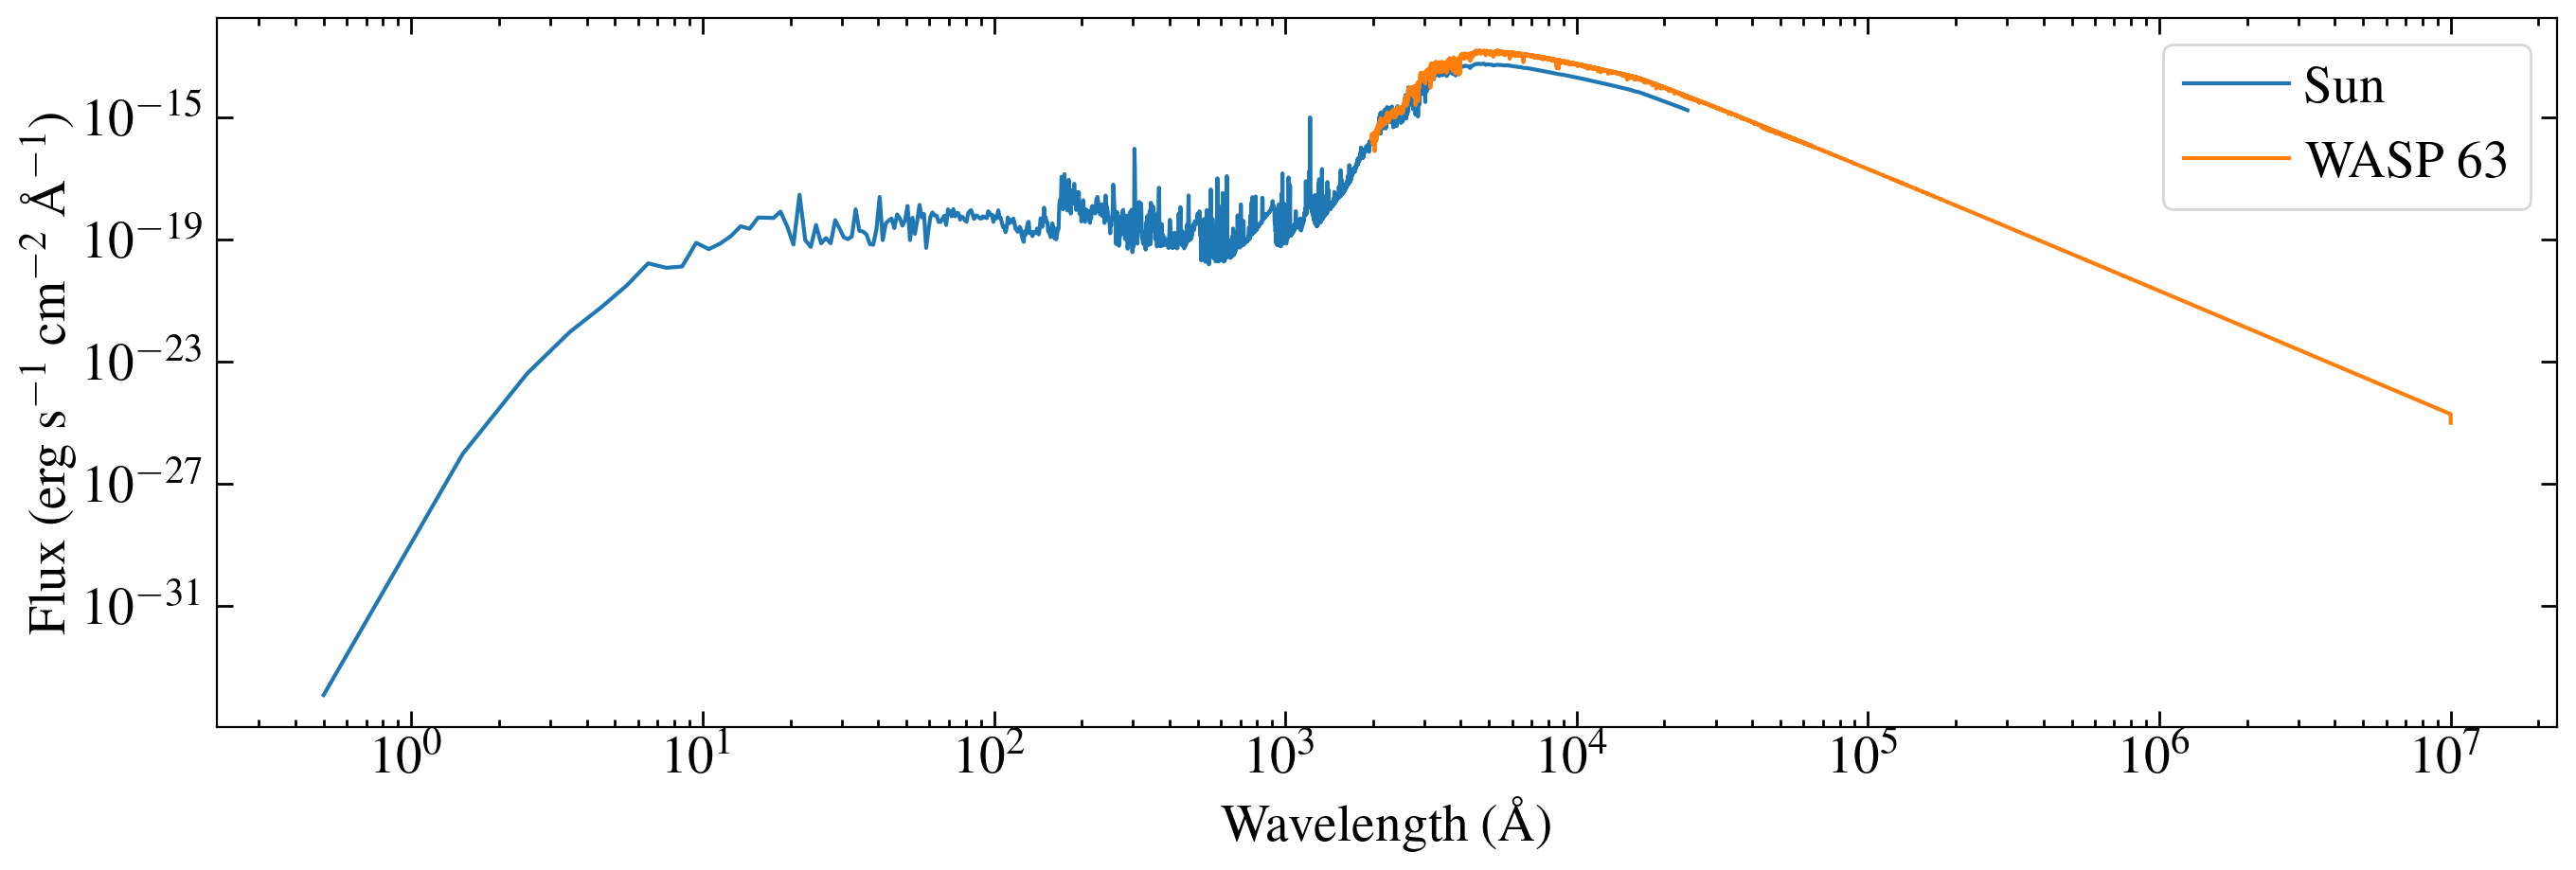

In [30]:
solscale= (((1*u.au).to(u.pc))/(d_63*u.pc))**2
print(solscale)

plt.plot(w_sol, f_sol*solscale, label='Sun')
plt.plot(w_full, f_full, label='WASP 63')
plt.yscale('log')
plt.xscale('log')
# plt.xlim(1500, 10000)
# plt.ylim(1e-17, 5e-13)

plt.legend(frameon=True)


plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')

plt.tight_layout()

plt.show()

# plt.plot(w_sol, f_sol*solscale)
# plt.plot(w_full, f_full)
# # plt.yscale('log')
# # plt.xscale('log')
# # plt.xlim(1000, 10000)
# plt.xlim(1900, 2150)
# plt.ylim(0, 2e-15)

In [31]:
proxmask = (w_sol > 5) & (w_sol < w_full[0])
proxw, proxf = w_sol[proxmask], f_sol[proxmask]* solscale
print(proxw[0], proxw[-1])

5.5 1979.5


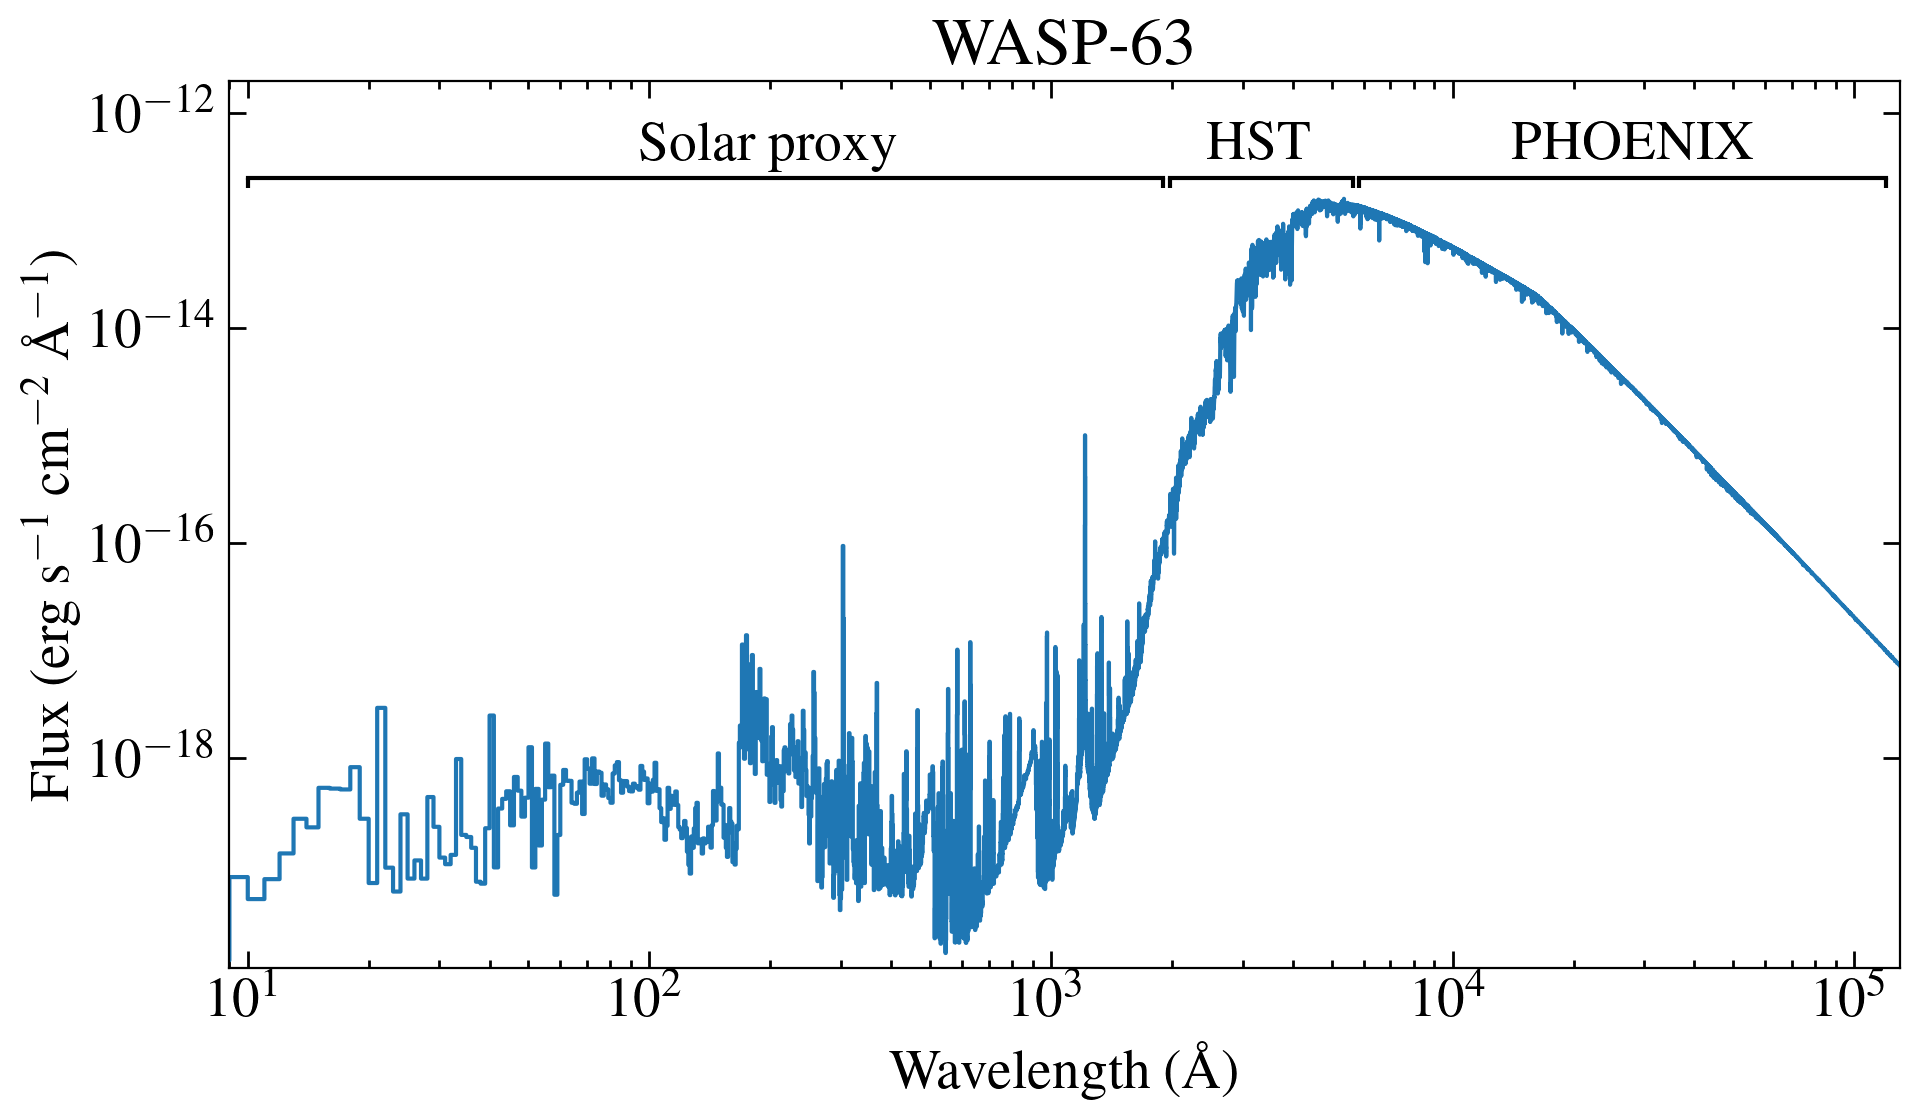

In [32]:
# pwi, pfi = smear(pw, pf, 10000)
# pmask = (pwi > 5650) #& (pwi < 100000)
# pwi, pfi = pwi[pmask], pfi[pmask]*normfac

fig, axes = plt.subplots(figsize=(10,6))
# gs = GridSpec(4, 1, figure=fig)
# plt.subplot(gs[0:3])
# plt.step(nw, nf, where='mid', label= 'G230L', c='C0')
# plt.step(nw, ne, where='mid', label= 'G230L')
# plt.step(ow[(ow > nw[-1])], of[(ow > nw[-1])], where='mid', label='G430L', zorder=-1, c='C0')
# plt.xlim(3200, 3400)
plt.plot(w_full, f_full, label='WASP 63', c='C0')

plt.xscale('log')
plt.yscale('log')

# plt.plot(pwi, pfi, label= 'PHOENIX', c='C0')

plt.step(proxw, proxf, c='C0', where='mid')
# plt.plot(pw[pw> 5650], pf[pw> 5650]*normfac, label= 'PHOENIX')
# plt.legend(frameon=True, loc=1)
plt.title('WASP-63')
plt.xlim(9, 130000)
plt.ylim(1.1e-20, 2.e-12)
# plt.xticks((3000, 10000, 40000), (3000, 10000, 40000))

liney = 2.5e-13
lineb = 0.5e-13
linescale = 1.5

# plt.errorbar(np.array([1900., nw[-1]]),np.array([liney, liney]),yerr=np.array([[lineb, lineb], [0.,0]]), c='k')
# plt.errorbar(np.array([ow[(ow > nw[-1])][0]+50, pwi[0]]),np.array([liney, liney]),yerr=np.array([[lineb, lineb], [0.,0]]), c='k')
plt.errorbar(np.array([1980, pwi[0]]),np.array([liney, liney]),yerr=np.array([[lineb, lineb], [0.,0]]), c='k')
plt.errorbar(np.array([10, 1900]),np.array([liney, liney]),yerr=np.array([[lineb, lineb], [0.,0]]), c='k')

plt.errorbar(np.array([pwi[0]+200, 120000.]),np.array([liney, liney]),yerr=np.array([[lineb, lineb], [0.,0]]), c='k')

plt.annotate('HST', (3300, liney*linescale, ), ha='center')
plt.annotate('Solar proxy', (200, liney*linescale, ), ha='center')
plt.annotate('PHOENIX', (28000, liney*linescale, ), ha='center')


# mplcyberpunk.add_glow_effects()
plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')

plt.tight_layout()
# plt.subplots_adjust(hspace=0.05)
plt.savefig('plots/WASP-63_v1sed.png', dpi=150)
plt.savefig('plots/WASP-63_v1sed.pdf')

In [33]:
# import mplcyberpunk
# plt.style.use('cyberpunk')


# # pwi, pfi = smear(pw, pf, 10000)
# # pmask = (pwi > 5650) #& (pwi < 100000)
# # pwi, pfi = pwi[pmask], pfi[pmask]*normfac

# fig, axes = plt.subplots(figsize=(10,6))
# # gs = GridSpec(4, 1, figure=fig)
# # plt.subplot(gs[0:3])
# # plt.step(nw, nf, where='mid', label= 'G230L', c='C4')
# # plt.step(nw, ne, where='mid', label= 'G230L')
# # plt.step(ow[(ow > nw[-1])], of[(ow > nw[-1])], where='mid', label='G430L', zorder=-1, c='C4')
# # plt.xlim(3200, 3400)
# plt.xscale('log')
# plt.yscale('log')
# plt.plot(w_full, f_full, label='WASP 63', c='C4')

# # plt.plot(pwi, pfi, label= 'PHOENIX', c='C4')

# plt.step(proxw, proxf, c='C4', where='mid')
# # plt.plot(pw[pw> 5650], pf[pw> 5650]*normfac, label= 'PHOENIX')
# # plt.legend(frameon=True, loc=1)
# plt.title('WASP-63')
# plt.xlim(9, 130000)
# plt.ylim(1.1e-20, 2.e-12)
# # plt.xticks((3000, 10000, 40000), (3000, 10000, 40000))

# liney = 2.5e-13
# lineb = 0.5e-13
# linescale = 1.5

# # plt.errorbar(np.array([1900., nw[-1]]),np.array([liney, liney]),yerr=np.array([[lineb, lineb], [0.,0]]), c='k')
# # plt.errorbar(np.array([ow[(ow > nw[-1])][0]+50, pwi[0]]),np.array([liney, liney]),yerr=np.array([[lineb, lineb], [0.,0]]), c='k')
# plt.errorbar(np.array([1980, pwi[0]]),np.array([liney, liney]),yerr=np.array([[lineb, lineb], [0.,0]]), c='C0')
# plt.errorbar(np.array([10, 1900]),np.array([liney, liney]),yerr=np.array([[lineb, lineb], [0.,0]]), c='C0')

# plt.errorbar(np.array([pwi[0]+200, 120000.]),np.array([liney, liney]),yerr=np.array([[lineb, lineb], [0.,0]]), c='C0')

# plt.annotate('HST', (3300, liney*linescale, ), ha='center')
# plt.annotate('Solar proxy', (200, liney*linescale, ), ha='center')
# plt.annotate('PHOENIX', (28000, liney*linescale, ), ha='center')


# mplcyberpunk.add_glow_effects()
# plt.xlabel('Wavelength (\AA)')
# plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')

# plt.tight_layout()
# # plt.subplots_adjust(hspace=0.05)
# plt.savefig('plots/WASP-63_v1sed_cp.png', dpi=150)
# plt.savefig('plots/WASP-63_v1sed_cp.pdf')

Which Solar spectrum is Kevin using? From https://lasp.colorado.edu/lisird/data/whi_ref_spectra. Third one, Quiet Sun.

In [34]:
# # plt.plot(w_sol, f_sol)

# nw, nf1, nf2, nf3, ns = np.loadtxt('../ref_solar_irradiance_whi-2008_ver2.dat', comments=';', skiprows=142, unpack=True)

# nw *= 10

# plt.plot(nw, f_sol/(nf1*100))
# plt.plot(nw, f_sol/(nf2*100))
# plt.plot(nw, f_sol/(nf3*100))

# # plt.plot(nw, f_sol/nf2)
# # plt.plot(nw, f_sol/nf3)



In [35]:
from craftroom import resample
from scipy.optimize import leastsq


[3.05112215e-16] 2.781681986760802e-16 [1.09686232]


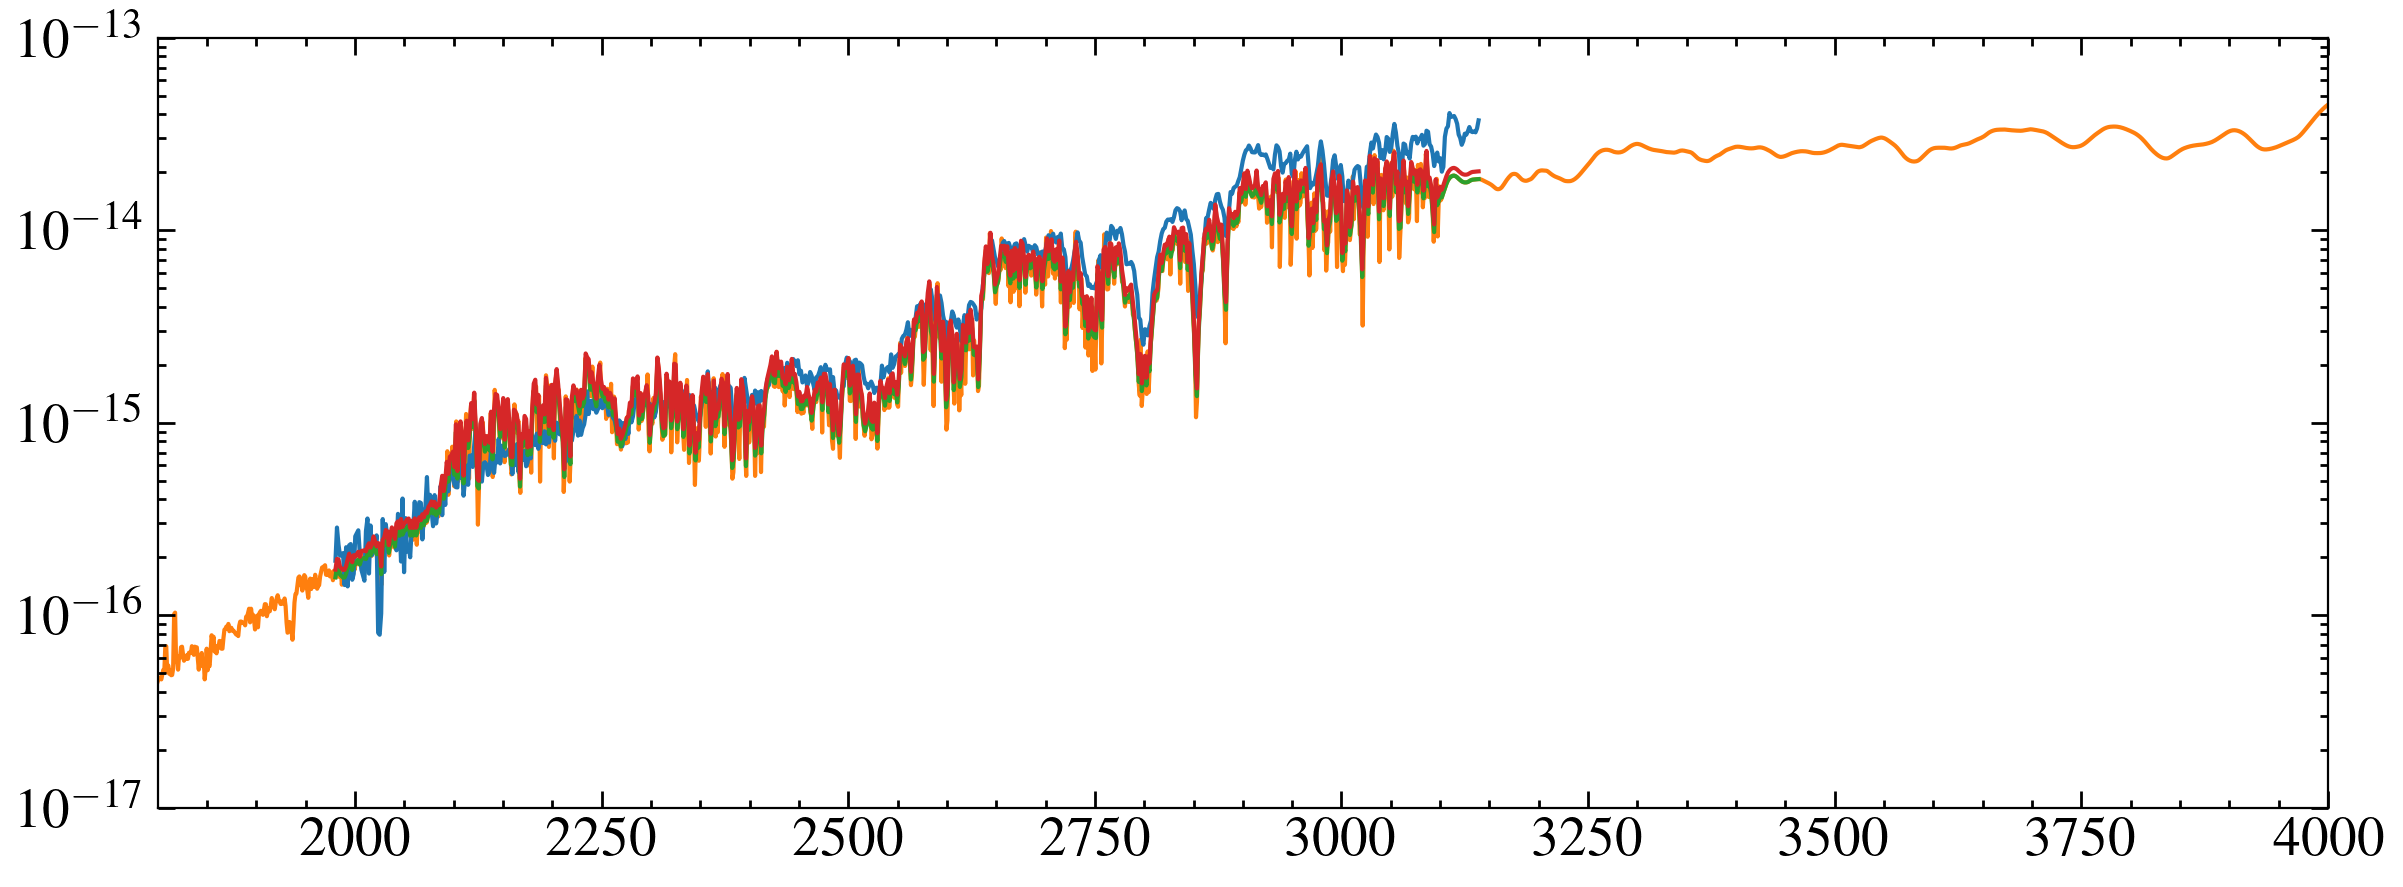

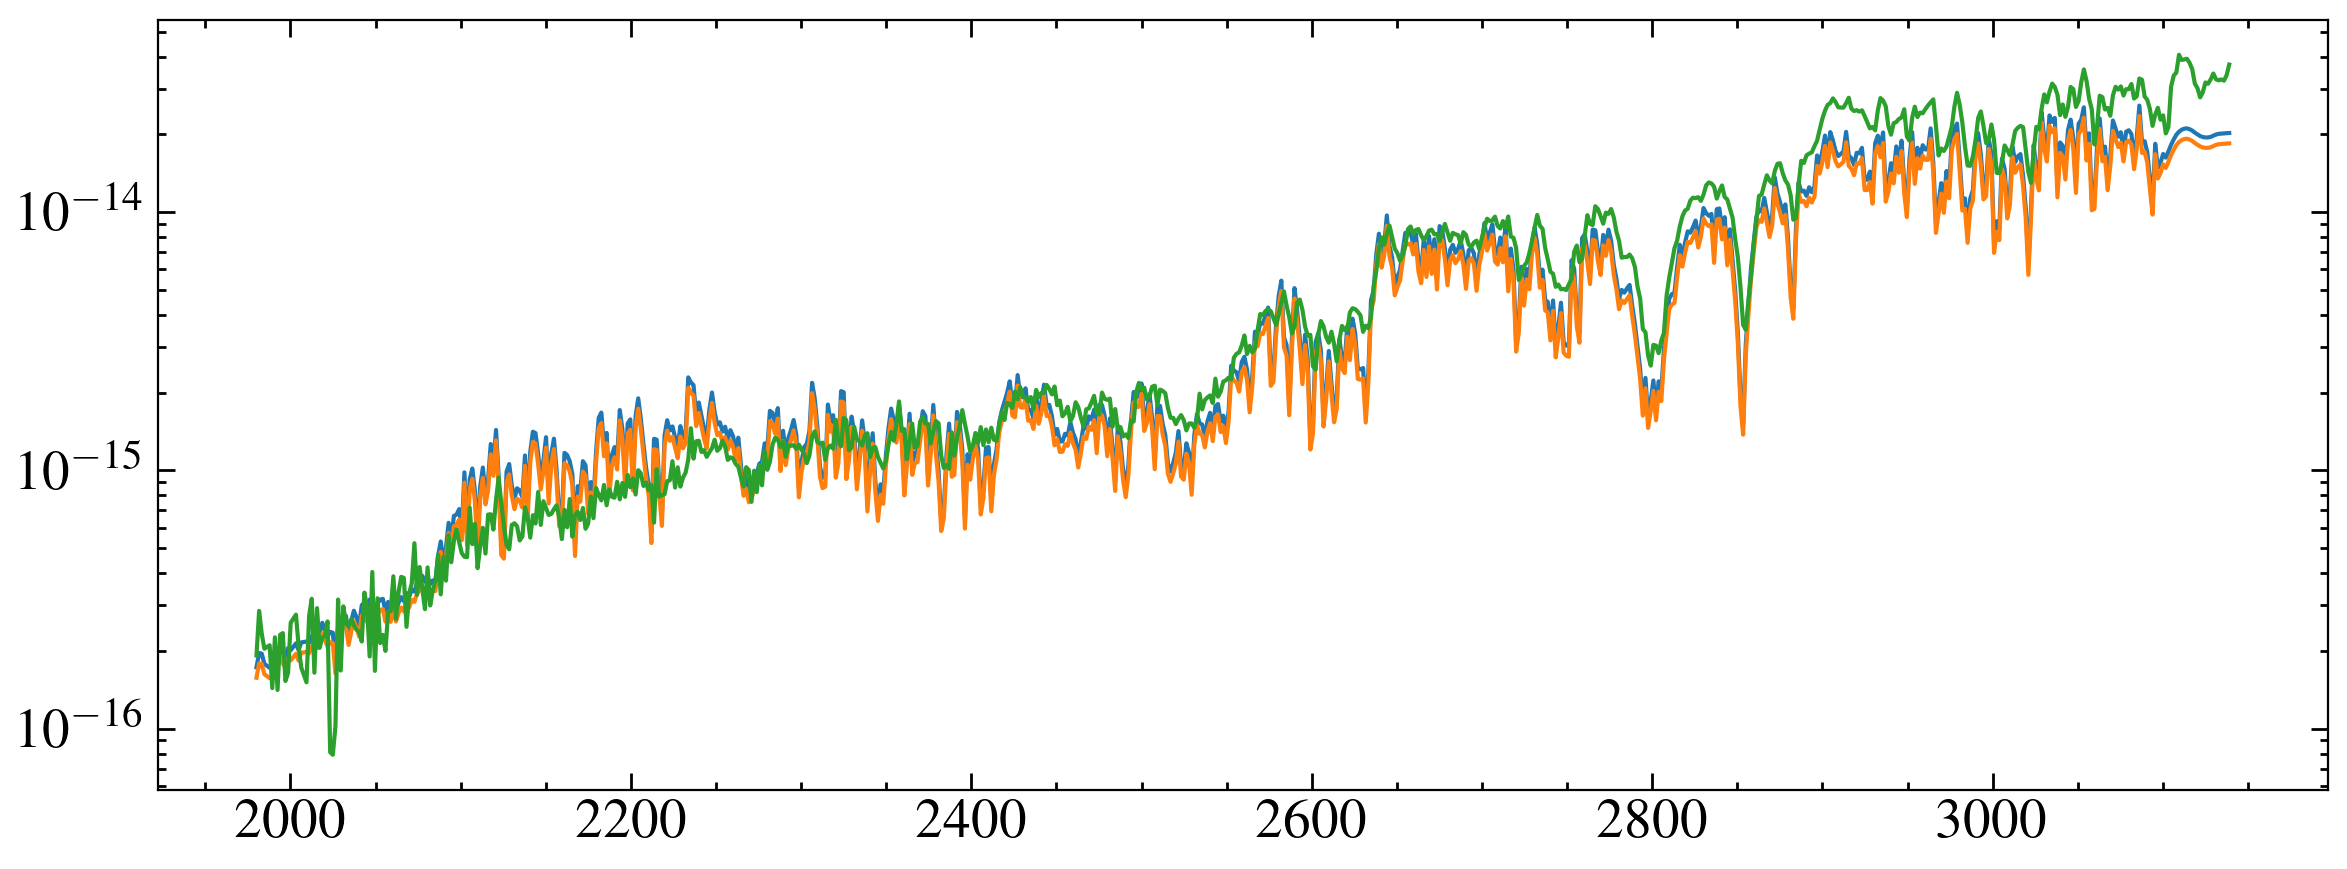

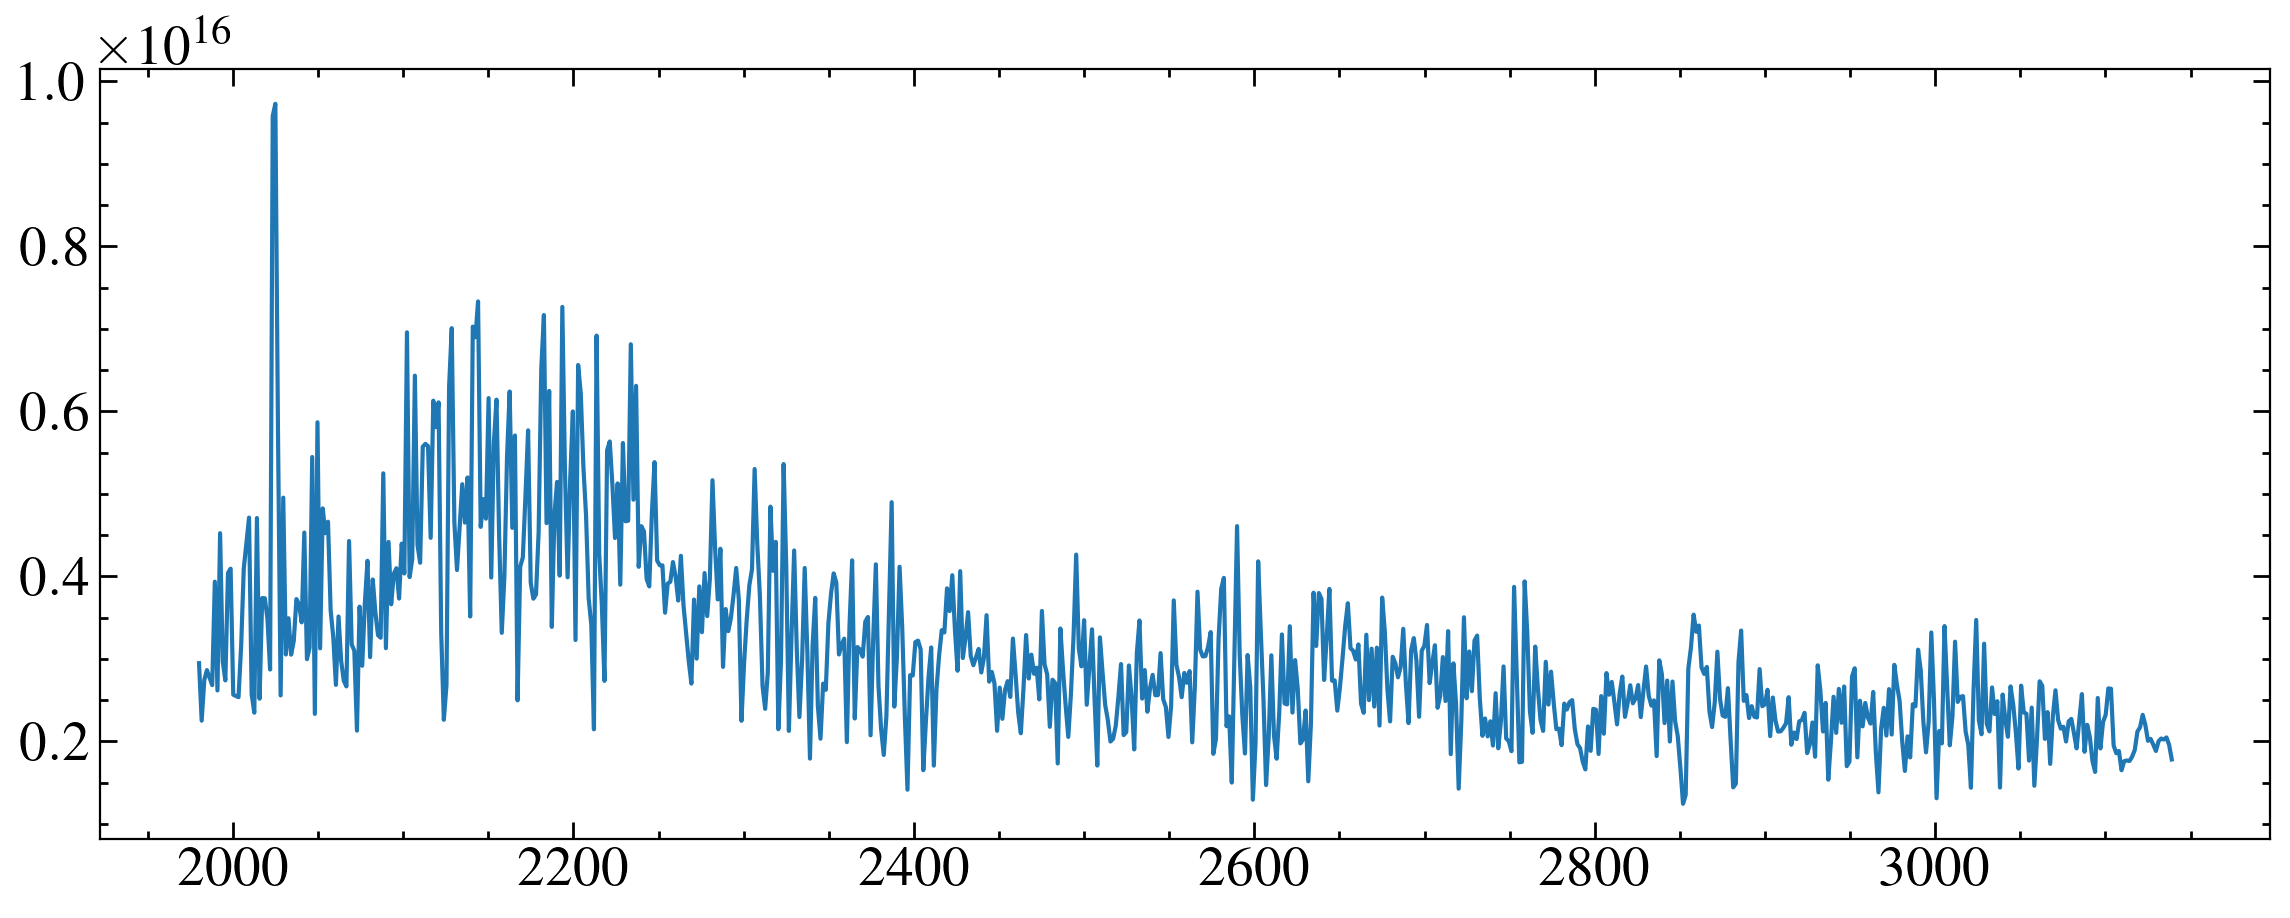

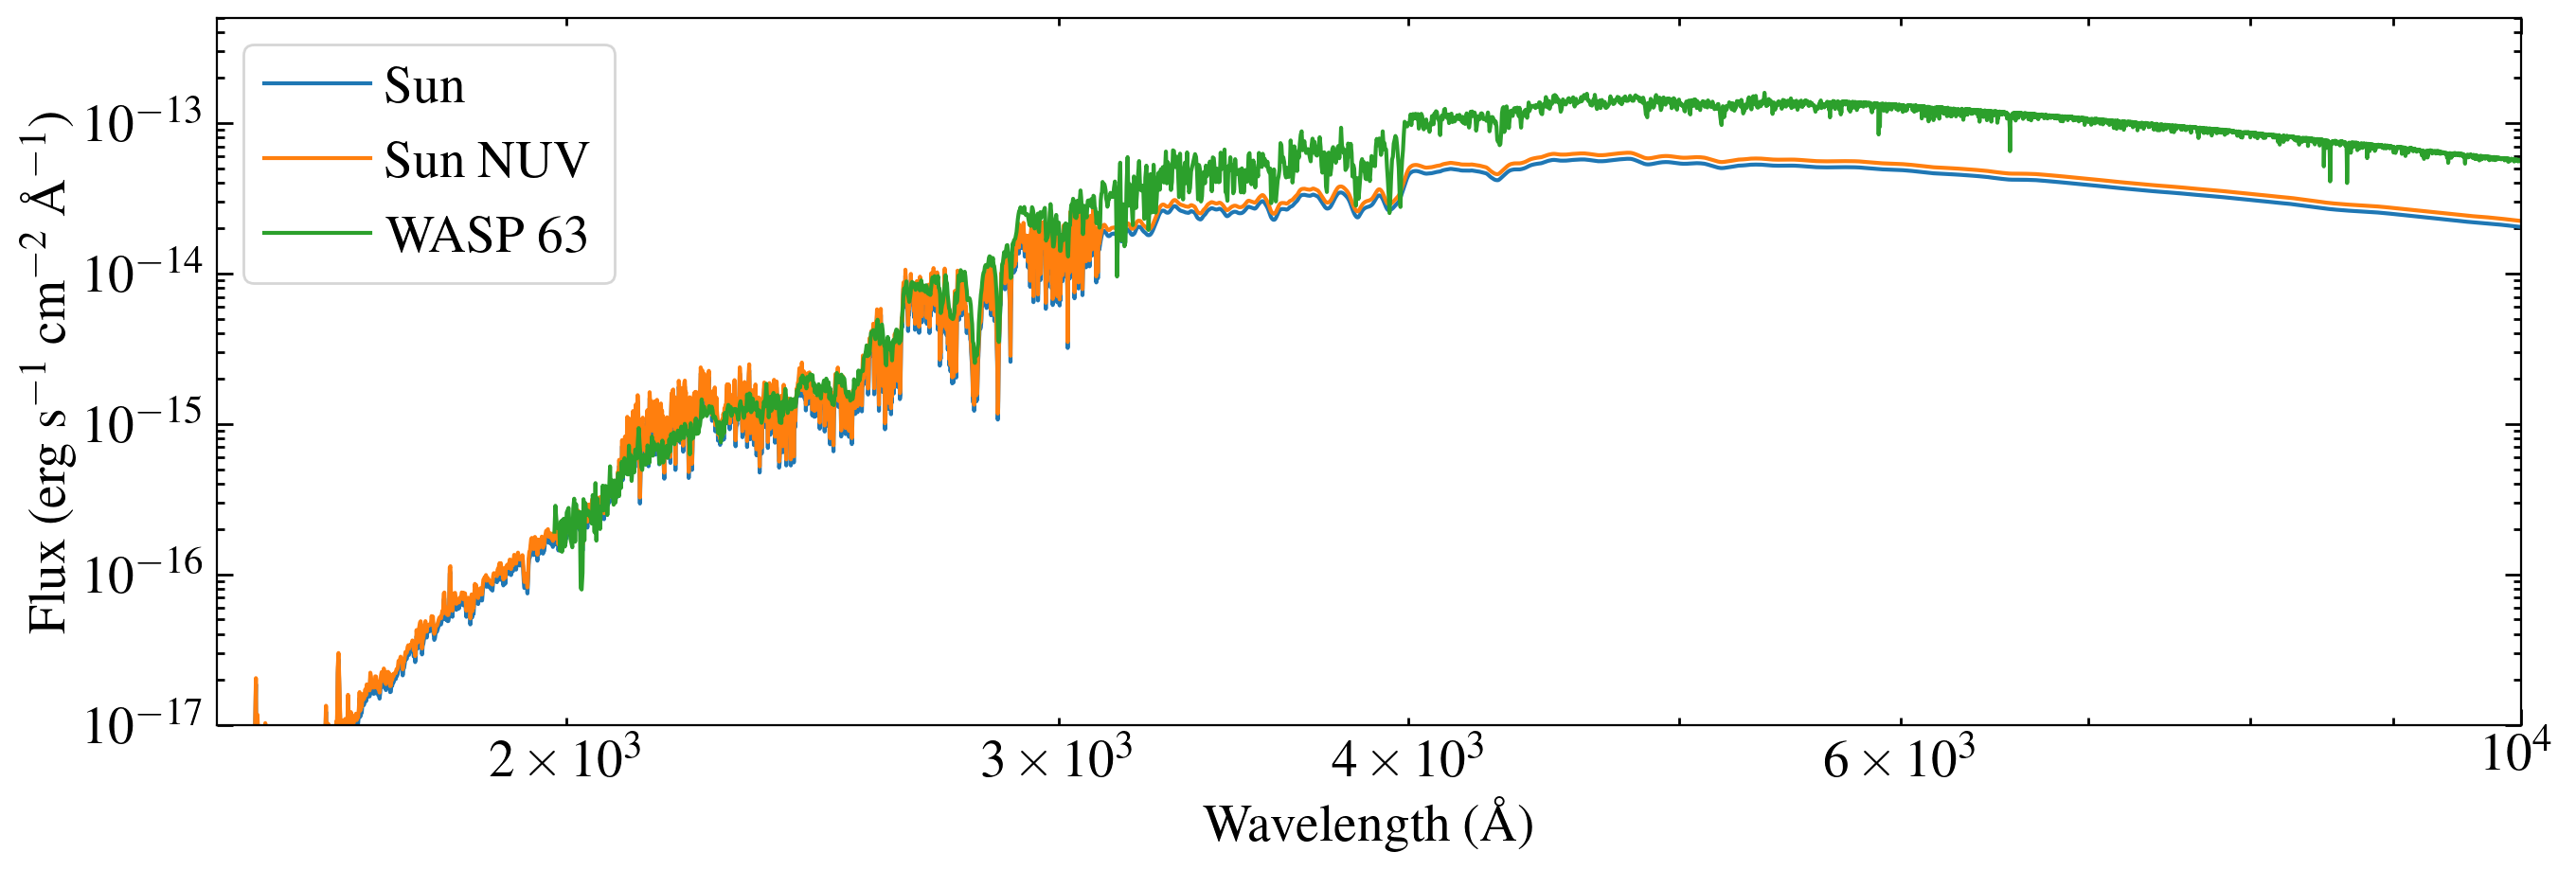

In [36]:
def residuals(scale, f, mf):
    return f - mf/scale

plt.plot(nw, nf)
plt.plot(w_sol, f_sol*solscale, zorder=-1)
plt.xlim(1800, 4000)
plt.ylim(1e-17, 1e-13)
plt.yscale('log')

#scaling with nuv flux instead
solnw, solnf = resample.bintogrid(w_sol, f_sol, newx=nw) 

plt.plot(solnw, solnf*solscale)
# plt.show()

# plt.plot(nw, solnf/nf)
mask = nw < 2600

nuvscale = 1/(leastsq(residuals, 1., args=(nf[mask], solnf[mask]))[0])

print(nuvscale, solscale, nuvscale/solscale)

plt.plot(solnw, solnf*nuvscale)

plt.show()
plt.plot(solnw, solnf*nuvscale)
plt.plot(solnw, solnf*solscale)
plt.plot(nw, nf)
plt.yscale('log')
plt.show()


plt.plot(nw, solnf/nf)

plt.show()



plt.plot(w_sol, f_sol*solscale, label='Sun')
plt.plot(w_sol, f_sol*nuvscale, label='Sun NUV')
plt.plot(w_full, f_full, label='WASP 63')
plt.yscale('log')
plt.xscale('log')
plt.xlim(1500, 10000)
plt.ylim(1e-17, 5e-13)

plt.legend(frameon=True)


plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')

plt.tight_layout()

plt.show()




Solution: Scale to NUV flux before 1600 (and after 1980). Errors with MC...

3.051383086922338e-16 1.2061288130737638e-18 3.051320823953312e-16


(array([  2.,   1.,   1.,   0.,   2.,   4.,   1.,   3.,   4.,   0.,   9.,
          9.,  11.,   7.,  11.,  22.,  20.,  21.,  32.,  29.,  40.,  52.,
         50.,  71.,  77.,  71.,  76., 101., 117., 108., 113., 155., 155.,
        183., 188., 202., 225., 240., 244., 247., 246., 312., 285., 283.,
        312., 331., 279., 314., 289., 295., 309., 298., 279., 280., 259.,
        236., 232., 192., 214., 204., 195., 171., 127., 122., 140., 117.,
        108., 103.,  77.,  63.,  69.,  56.,  42.,  46.,  42.,  32.,  27.,
         18.,  14.,  19.,  16.,  11.,   8.,   4.,   3.,   3.,   5.,   1.,
          2.,   0.,   1.,   1.,   1.,   2.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([3.00798121e-16, 3.00890096e-16, 3.00982071e-16, 3.01074046e-16,
        3.01166021e-16, 3.01257996e-16, 3.01349972e-16, 3.01441947e-16,
        3.01533922e-16, 3.01625897e-16, 3.01717872e-16, 3.01809847e-16,
        3.01901822e-16, 3.01993798e-16, 3.02085773e-16, 3.02177748e-16,
        3.02269723e-16, 3.0236

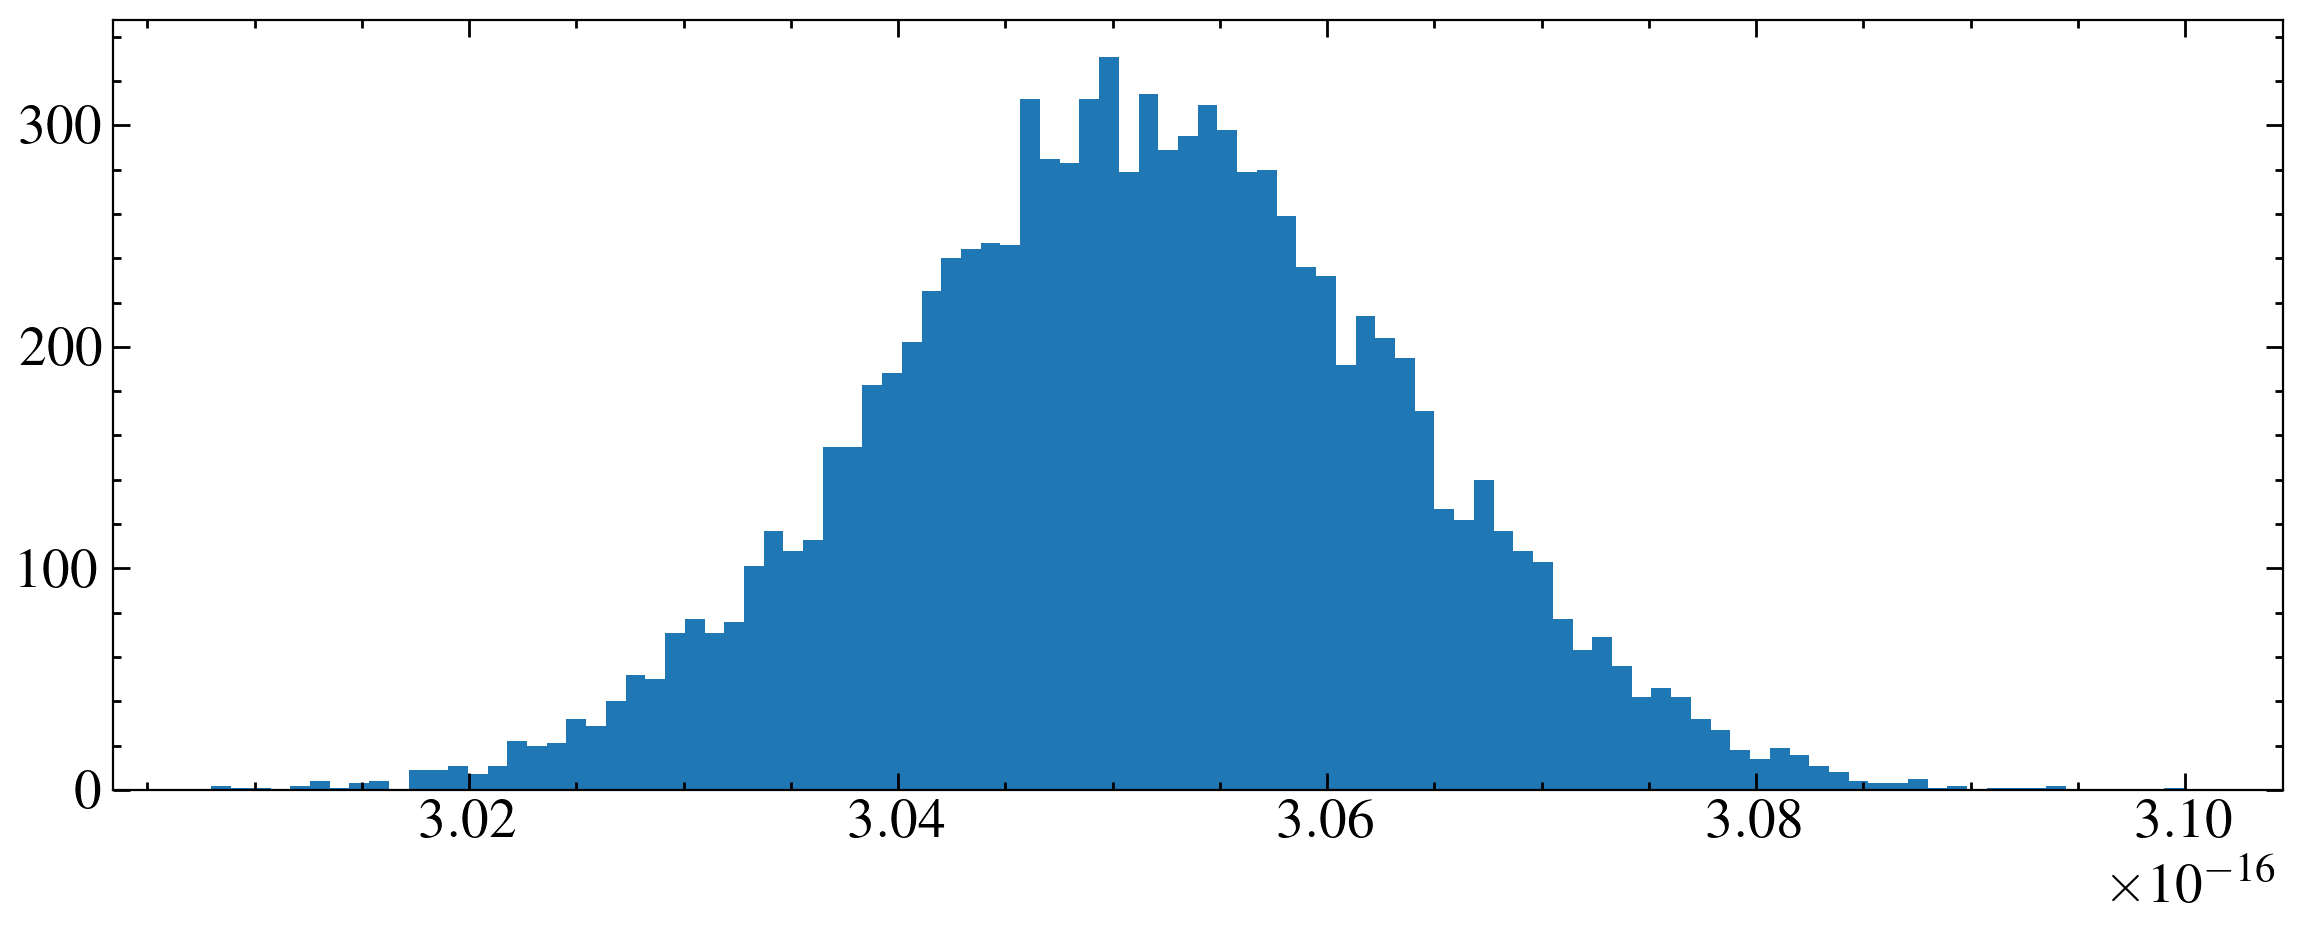

In [37]:
scales = []

nspec = 10000
scalemask = (nw < 2600)
nwscale, nfscale, nescale = nw[scalemask], nf[scalemask], ne[scalemask]
solnfscale = solnf[scalemask]

i = 0
while i < nspec:
    fi =  np.random.normal(nfscale, nescale)
    scalei = 1/(leastsq(residuals, 1., args=(fi, solnfscale))[0])
    scales.append(scalei)
    # plt.plot(nwscale, fi, alpha=0.1, c='C0')
    i += 1
    
scales = np.array(scales)
print(np.mean(scales), np.std(scales), np.median(scales))
# plt.plot(nwscale, nfscale, c='C1')
plt.hist(scales, bins=100)


In [38]:
scales10k = scales

nuvscale = np.mean(scales10k)
scales_e = np.std(scales10k)/np.mean(scales10k)
print(scales_e)

0.003952728250487486


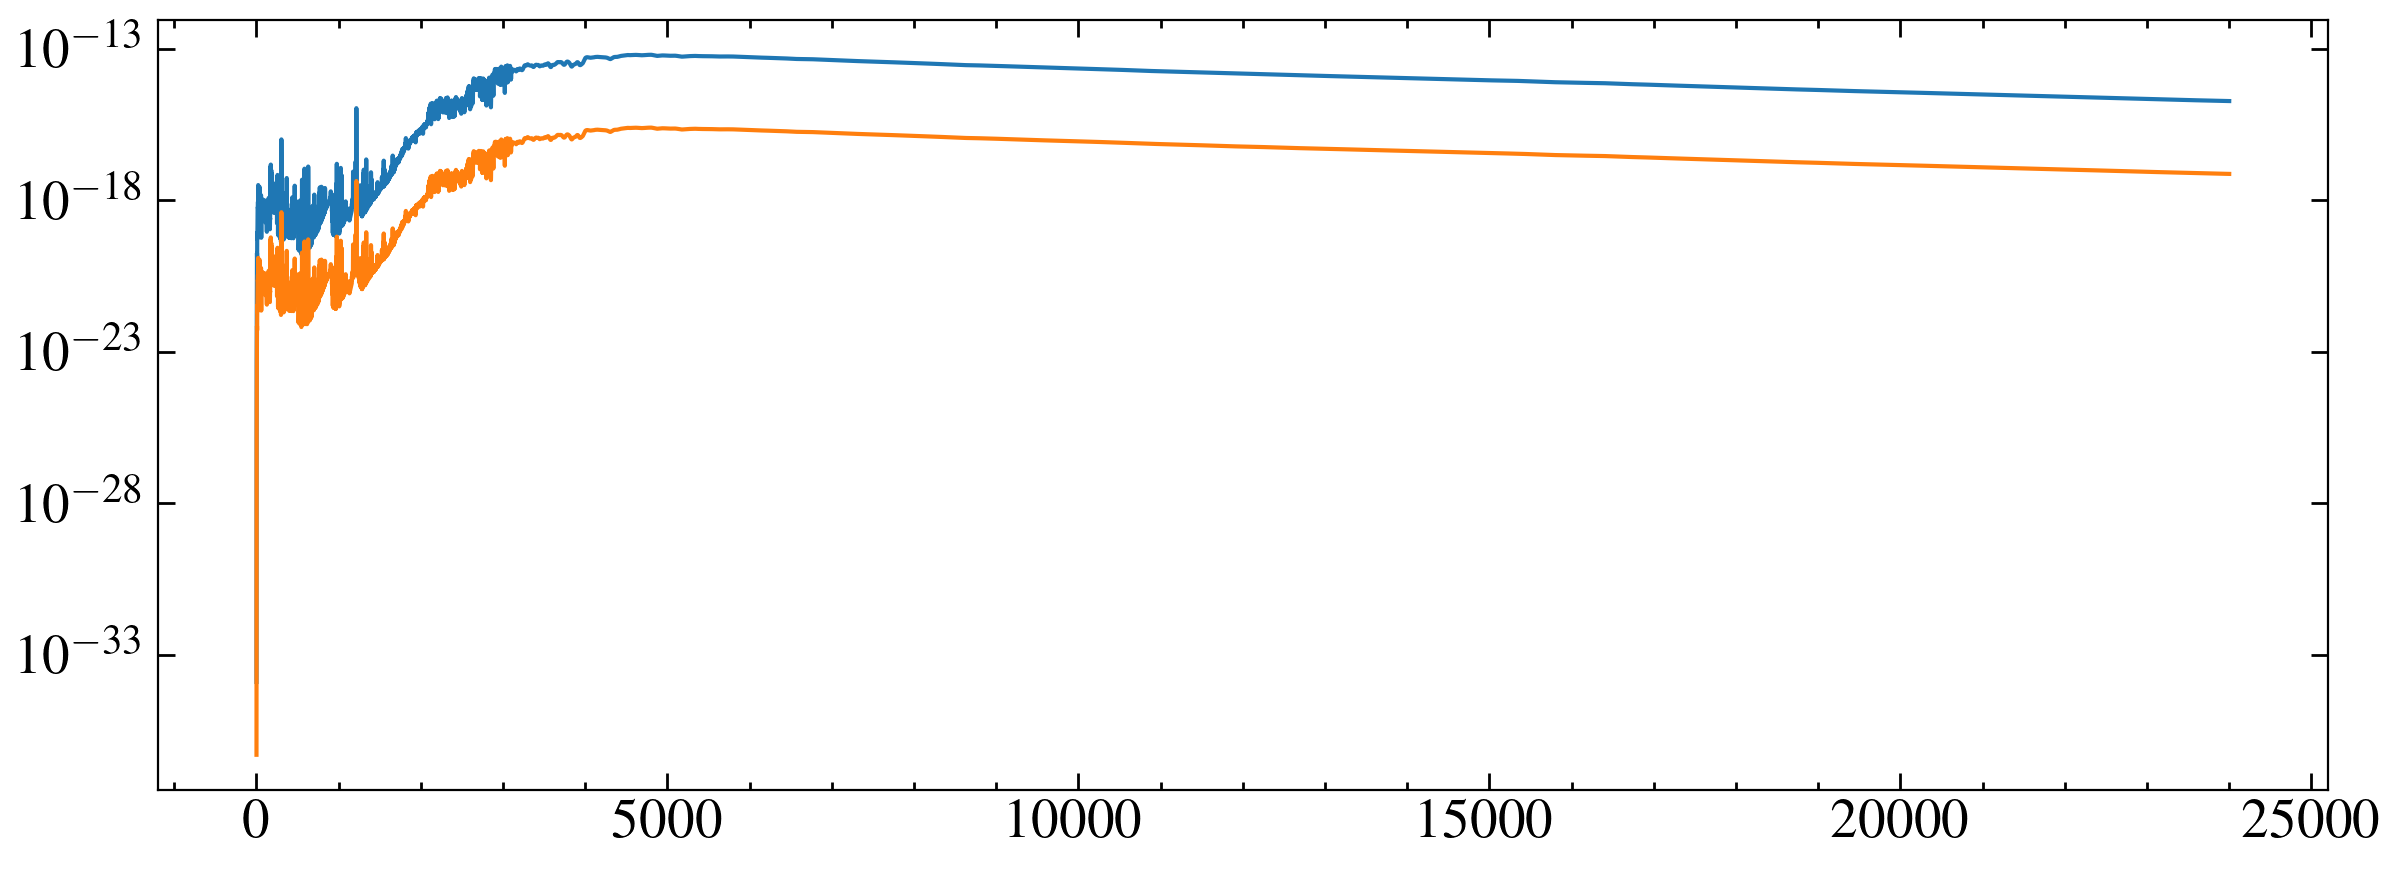

In [39]:
scaled_sol_f = f_sol *nuvscale
scaled_sol_e = scaled_sol_f*scales_e

plt.plot(w_sol, scaled_sol_f)
plt.plot(w_sol, scaled_sol_e)
plt.yscale('log')

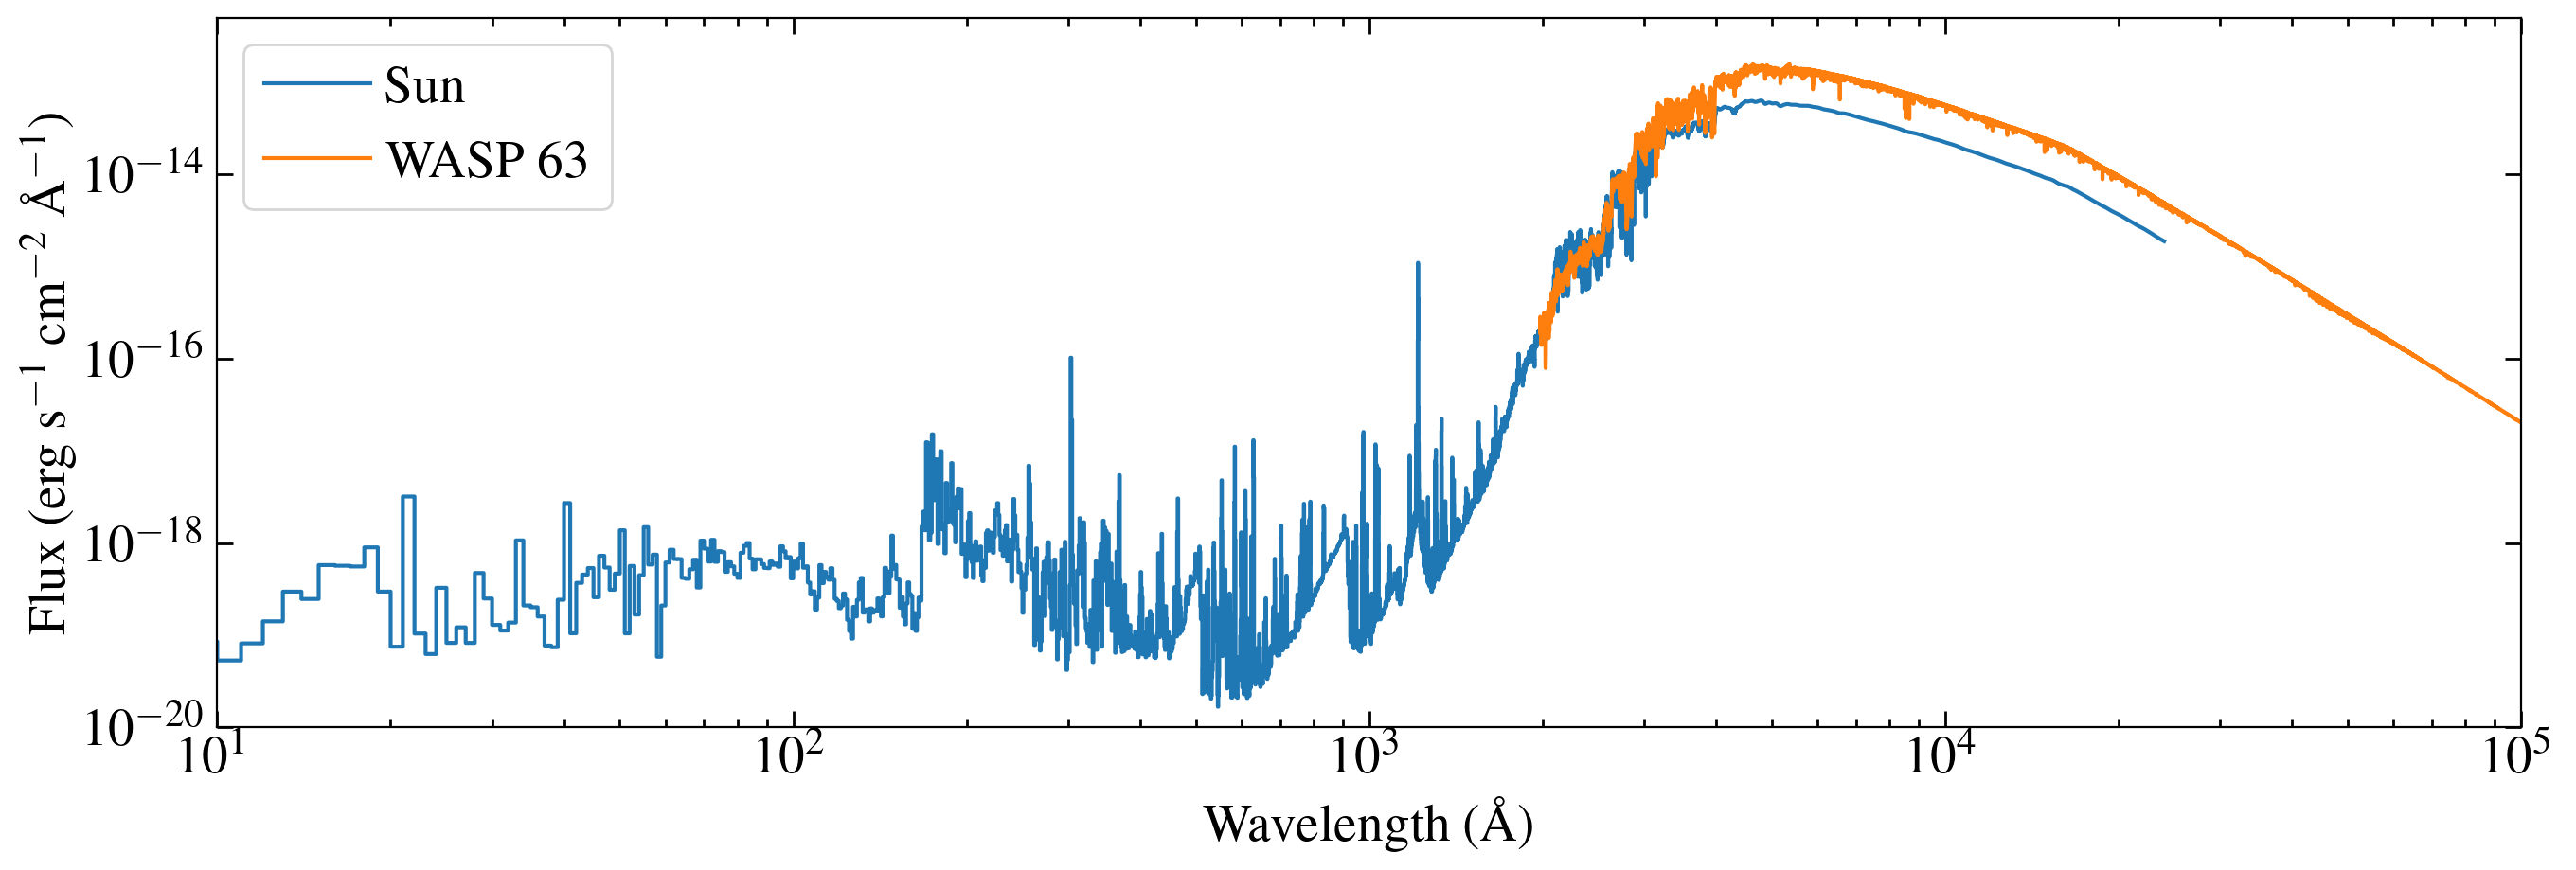

In [40]:
# plt.plot(w_sol, f_sol*solscale, label='Sun')
plt.step(w_sol, f_sol*nuvscale, where='mid', label='Sun')
plt.plot(w_full, f_full, label='WASP 63')
plt.yscale('log')
plt.xscale('log')
plt.xlim(10, 100000)
plt.ylim(1e-20, 5e-13)

plt.legend(frameon=True)


plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')

plt.tight_layout()


In [41]:
# tw, tf1, tf2, tf3, ts = np.loadtxt('../ref_solar_irradiance_whi-2008_ver2.dat', comments=';', skiprows=142, unpack=True)

# tw *= 10

# # plt.plot(tw, tf1*100)
# # plt.plot(tw, tf2*100)
# # plt.plot(tw, tf3*100)

# # plt.yscale('log')
# # plt.xscale('log')

# # plt.show()

# plt.plot(tw, tf3/tf1)
# # plt.plot(tw, tf3/tf2)
# plt.xlim(0, 4000)

Nice plots, then HLSP it all up. Spectra and full SED.

In [42]:
# import seaborn as sns
# sns.set_palette(sns.color_palette('tab10'))

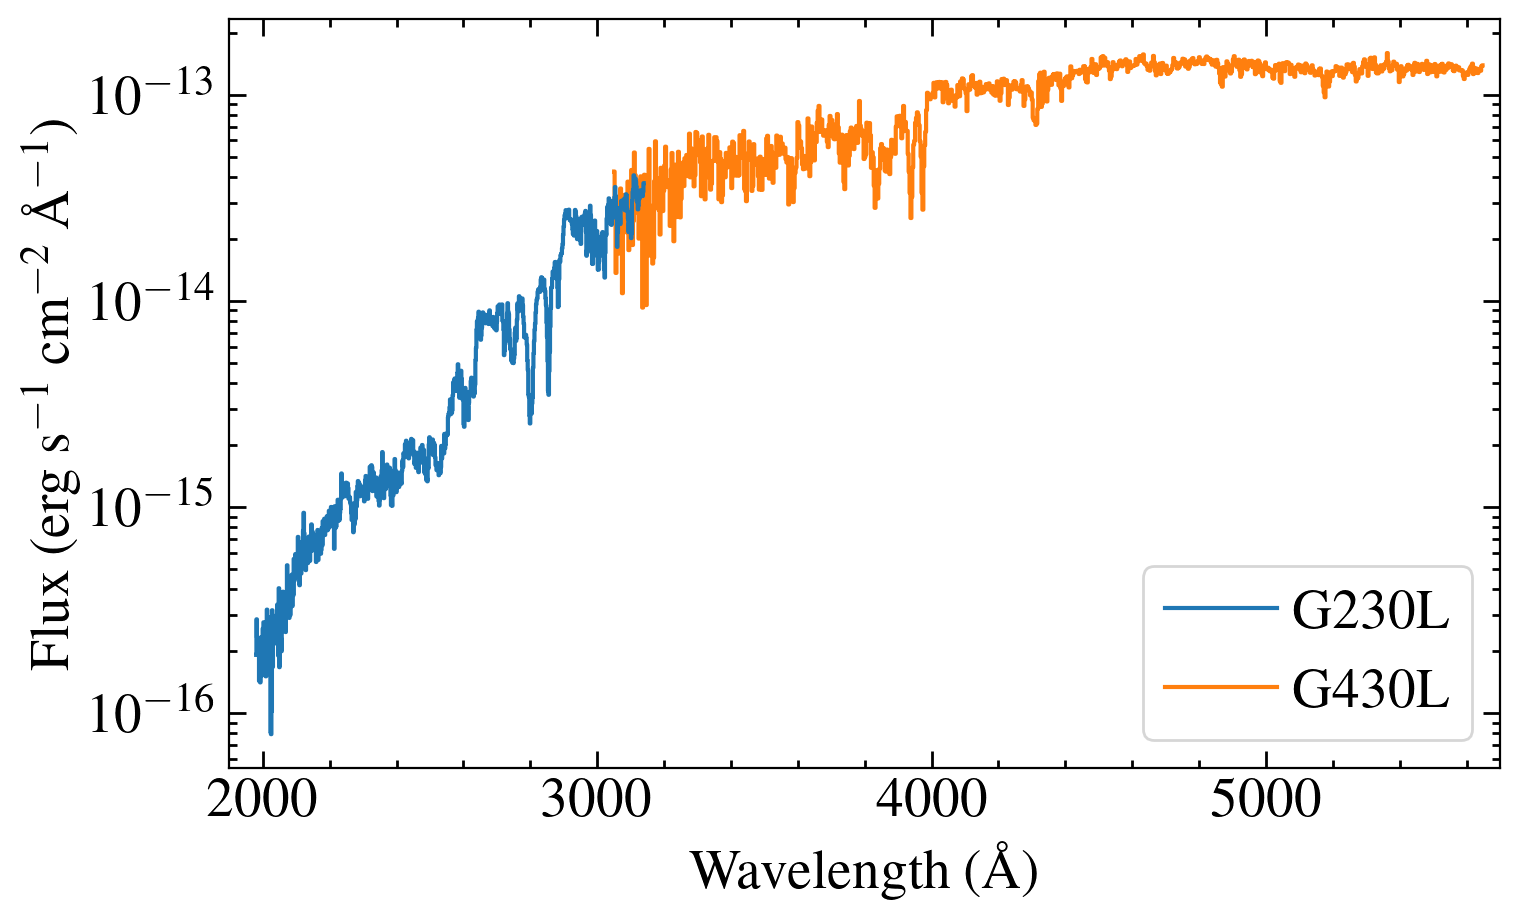

In [43]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.step(nw, nf, where='mid', label= 'G230L')
# plt.step(nw, ne, where='mid', label= 'G230L')
ax.step(ow, of, where='mid', label='G430L', zorder=-1)
# plt.xlim(3200, 3400)
# ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Wavelength (\AA)')
ax.set_ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
ax.legend(frameon=True, loc=4)
# plt.title('WASP-63')
plt.xlim(1900, 5700)
fig.tight_layout()

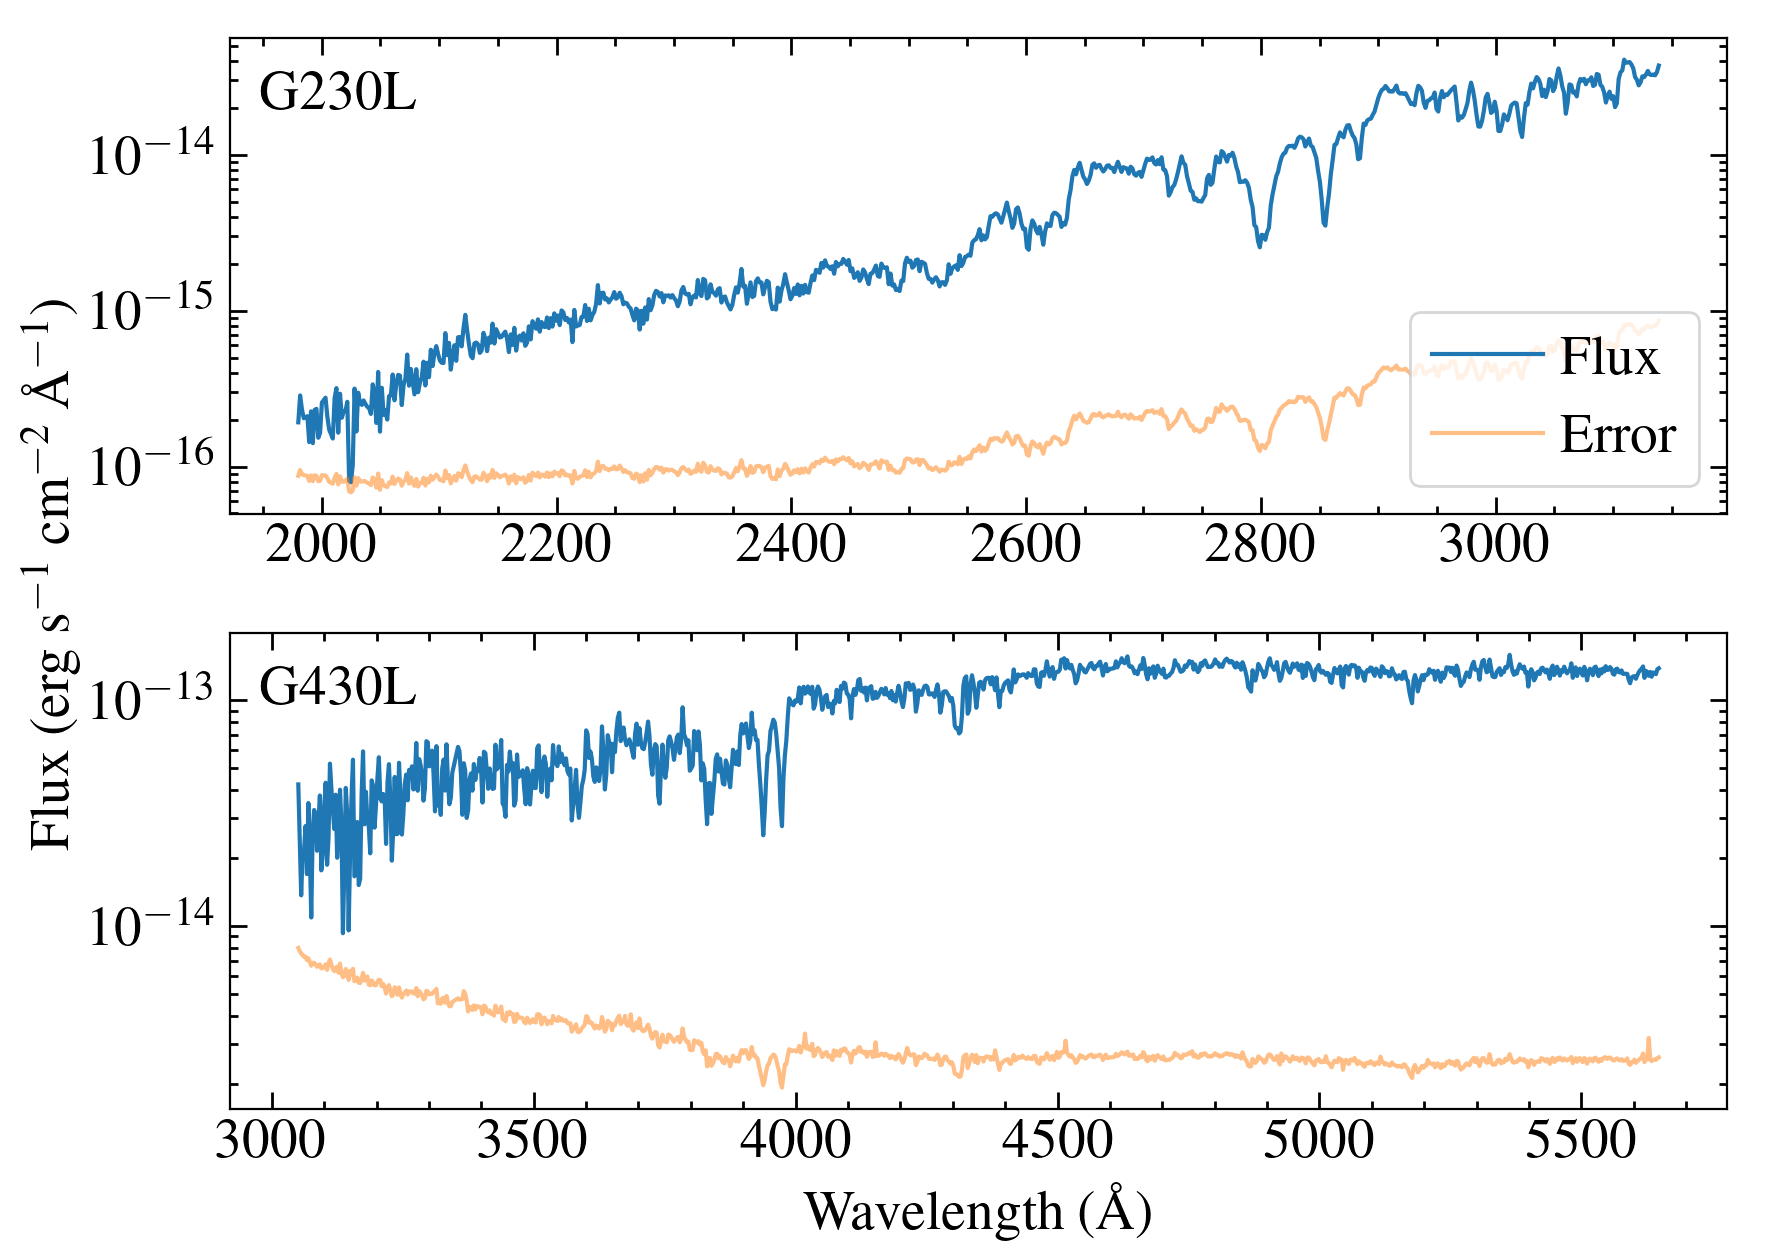

In [57]:
fig, ax = plt.subplots(figsize=(10, 7), nrows=2)
# ax[0].step(nw, nf, where='mid', label= 'Flux')
ax[0].plot(nw, nf, label= 'Flux')
ax[0].plot(nw, ne,  alpha=0.5, label='Error')
ax[1].plot(ow, of)
ax[1].plot(ow, oe,  alpha=0.5)
# plt.xlim(3200, 3400)
# ax.set_xscale('log')
ax[0].set_yscale('log')

ax[1].set_yscale('log')
ax[1].set_xlabel('Wavelength (\AA)')
# ax.set_ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
ax[0].legend(frameon=True, loc=4)
ax[0].annotate('G230L', (0.02, 0.93), xycoords='axes fraction', ha='left', va='top')
ax[1].annotate('G430L', (0.02, 0.93), xycoords='axes fraction', ha='left', va='top')

# plt.title('WASP-63')
# plt.xlim(1900, 5700)
fig.add_subplot(111, frame_on=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False, which='both')
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)', labelpad=25)
fig.tight_layout()
fig.savefig('plots/wasp-63_spectra.png')
fig.savefig('plots/wasp-63_spectra.pdf')


In [58]:
proxmask = (w_sol > 5) & (w_sol < w_full[0])
proxw, proxf = w_sol[proxmask], f_sol[proxmask]* nuvscale
print(proxw[0], proxw[-1])

5.5 1979.5


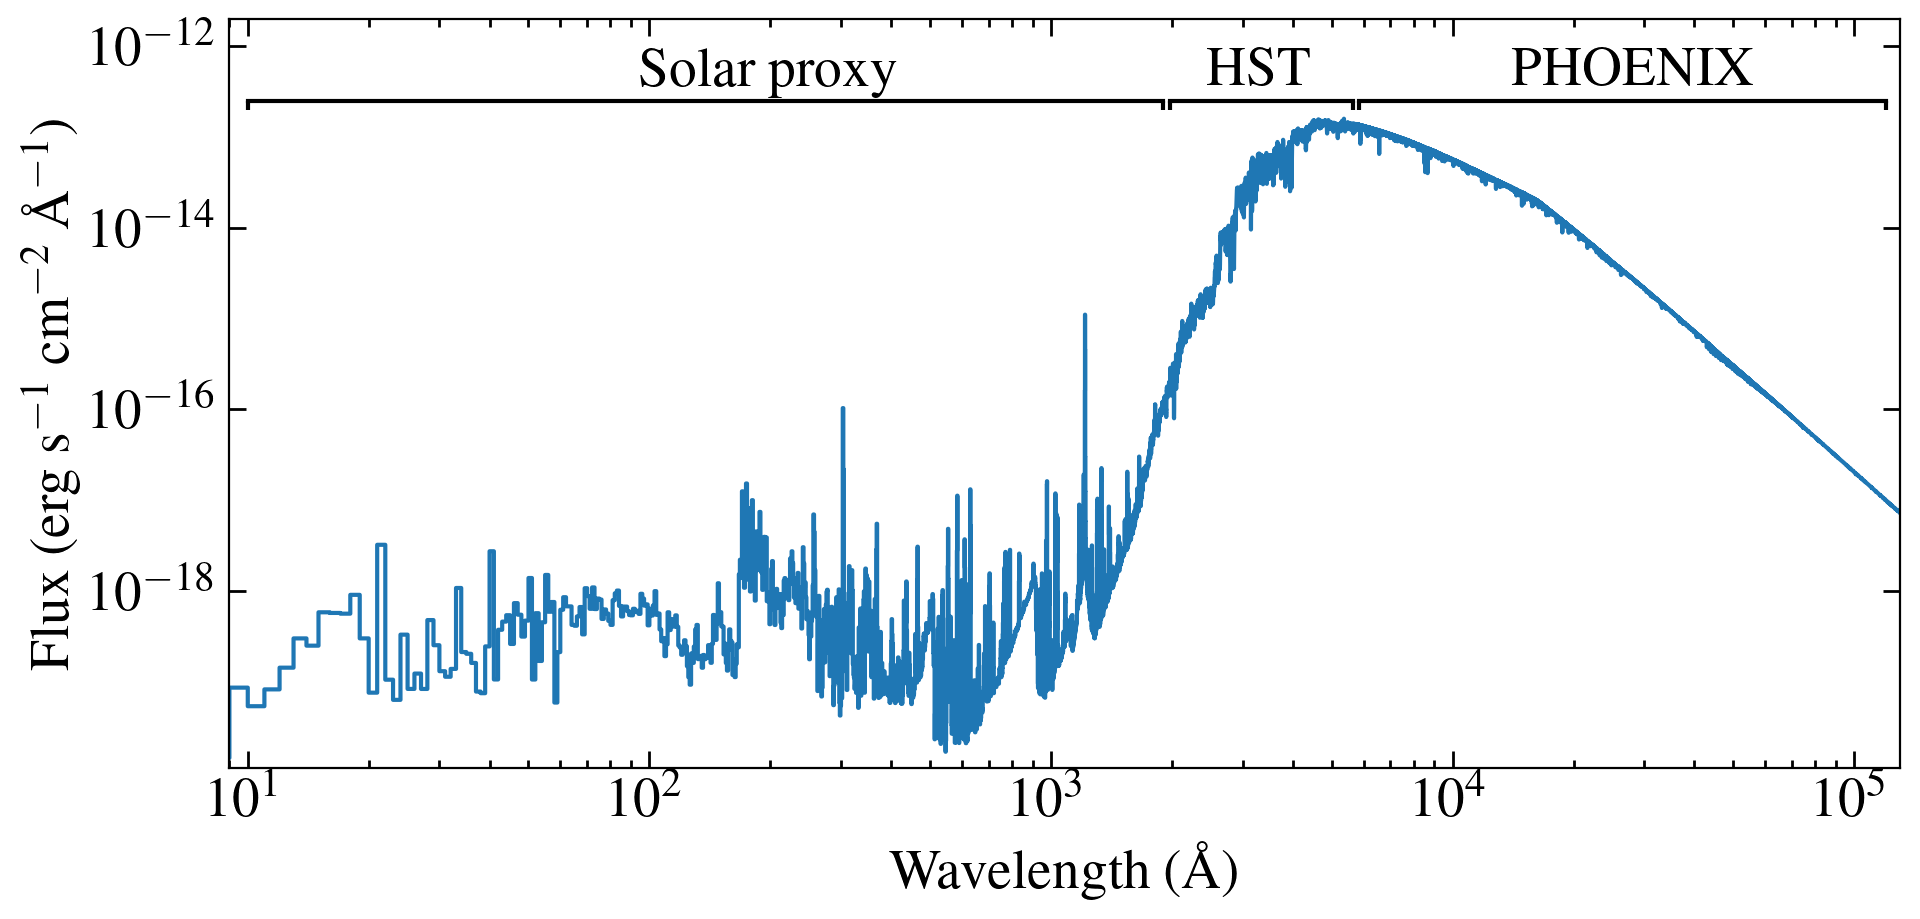

In [61]:
# pwi, pfi = smear(pw, pf, 10000)
# pmask = (pwi > 5650) #& (pwi < 100000)
# pwi, pfi = pwi[pmask], pfi[pmask]*normfac

fig, axes = plt.subplots(figsize=(10,5))
# gs = GridSpec(4, 1, figure=fig)
# plt.subplot(gs[0:3])
# plt.step(nw, nf, where='mid', label= 'G230L', c='C0')
# plt.step(nw, ne, where='mid', label= 'G230L')
# plt.step(ow[(ow > nw[-1])], of[(ow > nw[-1])], where='mid', label='G430L', zorder=-1, c='C0')
# plt.xlim(3200, 3400)
plt.plot(w_full, f_full, label='WASP 63', c='C0')

plt.xscale('log')
plt.yscale('log')

# plt.plot(pwi, pfi, label= 'PHOENIX', c='C0')

plt.step(proxw, proxf, c='C0', where='mid')
# plt.plot(pw[pw> 5650], pf[pw> 5650]*normfac, label= 'PHOENIX')
# plt.legend(frameon=True, loc=1)
# plt.title('WASP-63')
plt.xlim(9, 130000)
plt.ylim(1.1e-20, 2.e-12)
# plt.xticks((3000, 10000, 40000), (3000, 10000, 40000))

liney = 2.5e-13
lineb = 0.5e-13
linescale = 1.5

# plt.errorbar(np.array([1900., nw[-1]]),np.array([liney, liney]),yerr=np.array([[lineb, lineb], [0.,0]]), c='k')
# plt.errorbar(np.array([ow[(ow > nw[-1])][0]+50, pwi[0]]),np.array([liney, liney]),yerr=np.array([[lineb, lineb], [0.,0]]), c='k')
plt.errorbar(np.array([1980, pwi[0]]),np.array([liney, liney]),yerr=np.array([[lineb, lineb], [0.,0]]), c='k')
plt.errorbar(np.array([10, 1900]),np.array([liney, liney]),yerr=np.array([[lineb, lineb], [0.,0]]), c='k')

plt.errorbar(np.array([pwi[0]+200, 120000.]),np.array([liney, liney]),yerr=np.array([[lineb, lineb], [0.,0]]), c='k')

plt.annotate('HST', (3300, liney*linescale, ), ha='center')
plt.annotate('Solar proxy', (200, liney*linescale, ), ha='center')
plt.annotate('PHOENIX', (28000, liney*linescale, ), ha='center')


# mplcyberpunk.add_glow_effects()
plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')

plt.tight_layout()
# plt.subplots_adjust(hspace=0.05)
plt.savefig('plots/WASP-63_v2sed.png', dpi=150)
plt.savefig('plots/WASP-63_v2sed.pdf')

In [67]:
print((max(pw)*u.AA).to(u.um))
print(max(pw))

999.5000000000002 um
9995000.0
